# UBS Hackathon 2023
## SHAP Explainer (Diabetes Data)

In [61]:
#!pip install catboost
#https://www.kaggle.com/code/jonaspalucibarbosa/telco-customer-churn-eda-predictions-shap

In [3]:
import pandas as pd 
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Apparently, there are no missing values. But there is clearly an error. ‘Total Charges’ should be numeric. We can use pd.to_numeric to convert it.

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].dtype

dtype('float64')

After changing a column from string to numeric, some values may not be recognized, resulting in missing values. Let’s check if this happened.

In [8]:
df['TotalCharges'].isnull().sum()

11

Now there are supposedly 11 missing values, but they might indicate that there were no charges for that customer up to the point when the data was obtained. The feature 'tenure' indicates for how long someone has been a customer. Let's check the number of samples with value '0' on that feature and, in case we also find 11 customers, compare if their index match those from the 'missing' values.

In [9]:
df['tenure'].isin([0]).sum()

11

In [10]:
print(df[df['tenure'].isin([0])].index)
print(df[df['TotalCharges'].isna()].index)

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')
Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')


We got a match here. After confirming our suspects, we can replace those missing values with '0'.

In [11]:
df.loc[:,'TotalCharges'] = df.loc[:,'TotalCharges'].replace(np.nan,0)
df['TotalCharges'].isnull().sum()

0

The feature 'Senior Citizen', which is categorical ('Yes' or 'No'), is set as numeric. Although all features will be changed to numeric to be used in our prediction models, I'll convert it from numeric to string for now.

In [12]:
df['SeniorCitizen'] = df['SeniorCitizen'].apply(str)
senior_map = {'0': 'No', '1': 'Yes'}
df['SeniorCitizen'] = df['SeniorCitizen'].map(senior_map)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Let's finish this section by checking the possible values of categorical features and viewing descriptive statistics (df.describe) for numerical features.

In [13]:
for col in df.select_dtypes('object').columns:
    print(col, '- # unique values:', df[col].nunique())

customerID - # unique values: 7043
gender - # unique values: 2
SeniorCitizen - # unique values: 2
Partner - # unique values: 2
Dependents - # unique values: 2
PhoneService - # unique values: 2
MultipleLines - # unique values: 3
InternetService - # unique values: 3
OnlineSecurity - # unique values: 3
OnlineBackup - # unique values: 3
DeviceProtection - # unique values: 3
TechSupport - # unique values: 3
StreamingTV - # unique values: 3
StreamingMovies - # unique values: 3
Contract - # unique values: 3
PaperlessBilling - # unique values: 2
PaymentMethod - # unique values: 4
Churn - # unique values: 2


In [14]:
for col in df.select_dtypes('object').columns:
    print(col, '\n')
    print(df[col].value_counts(), '\n')

customerID 

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64 

gender 

Male      3555
Female    3488
Name: gender, dtype: int64 

SeniorCitizen 

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64 

Partner 

No     3641
Yes    3402
Name: Partner, dtype: int64 

Dependents 

No     4933
Yes    2110
Name: Dependents, dtype: int64 

PhoneService 

Yes    6361
No      682
Name: PhoneService, dtype: int64 

MultipleLines 

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64 

InternetService 

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 

OnlineSecurity 

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64 

OnlineBackup 

No              

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


EDA

CHURN

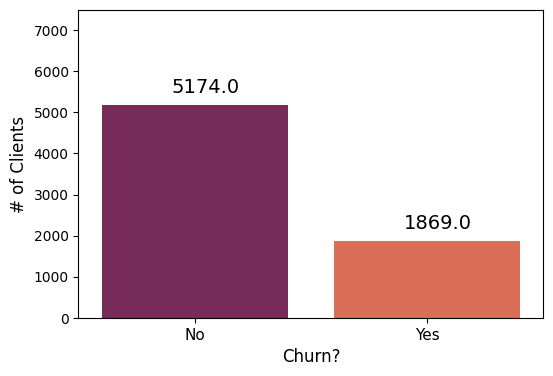

In [16]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x="Churn", data=df, palette="rocket")

plt.xlabel("Churn?", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,7500)
plt.xticks([0,1], ['No', 'Yes'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 14)
    
plt.show()

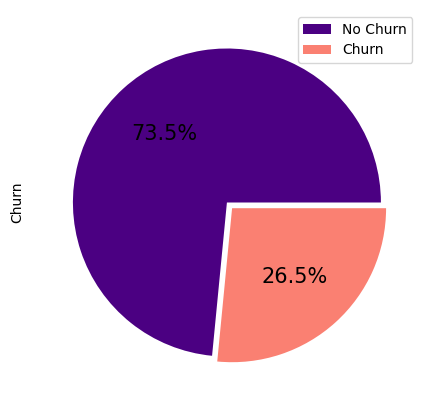

In [17]:
plt.figure(figsize=(7,5))

df['Churn'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['indigo','salmon'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['No Churn', 'Churn'])
plt.show()

At the period represented in this dataset, there is a 26,5% rate of customer churn. As we move on to analyze the features, we can compare this number with the percentage of churn found for each category, providing us a better idea on the impact of a given feature in the company’s ability to retain its customers.

In [18]:
#Label encoding Churn to use sns.barplot
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

We can divide the features into the following groups:

Demographic features;
Service-related features
Account information related features (categorical and numerical).
For each group, we’ll start by looking at the features’ distributions. Then, we’ll check the percentage of churn for each category to understand their relationship with the target.

In [19]:
demo_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

serv_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup'
                , 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

cat_accinfo_features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

num_accinfo_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

Demographic Features

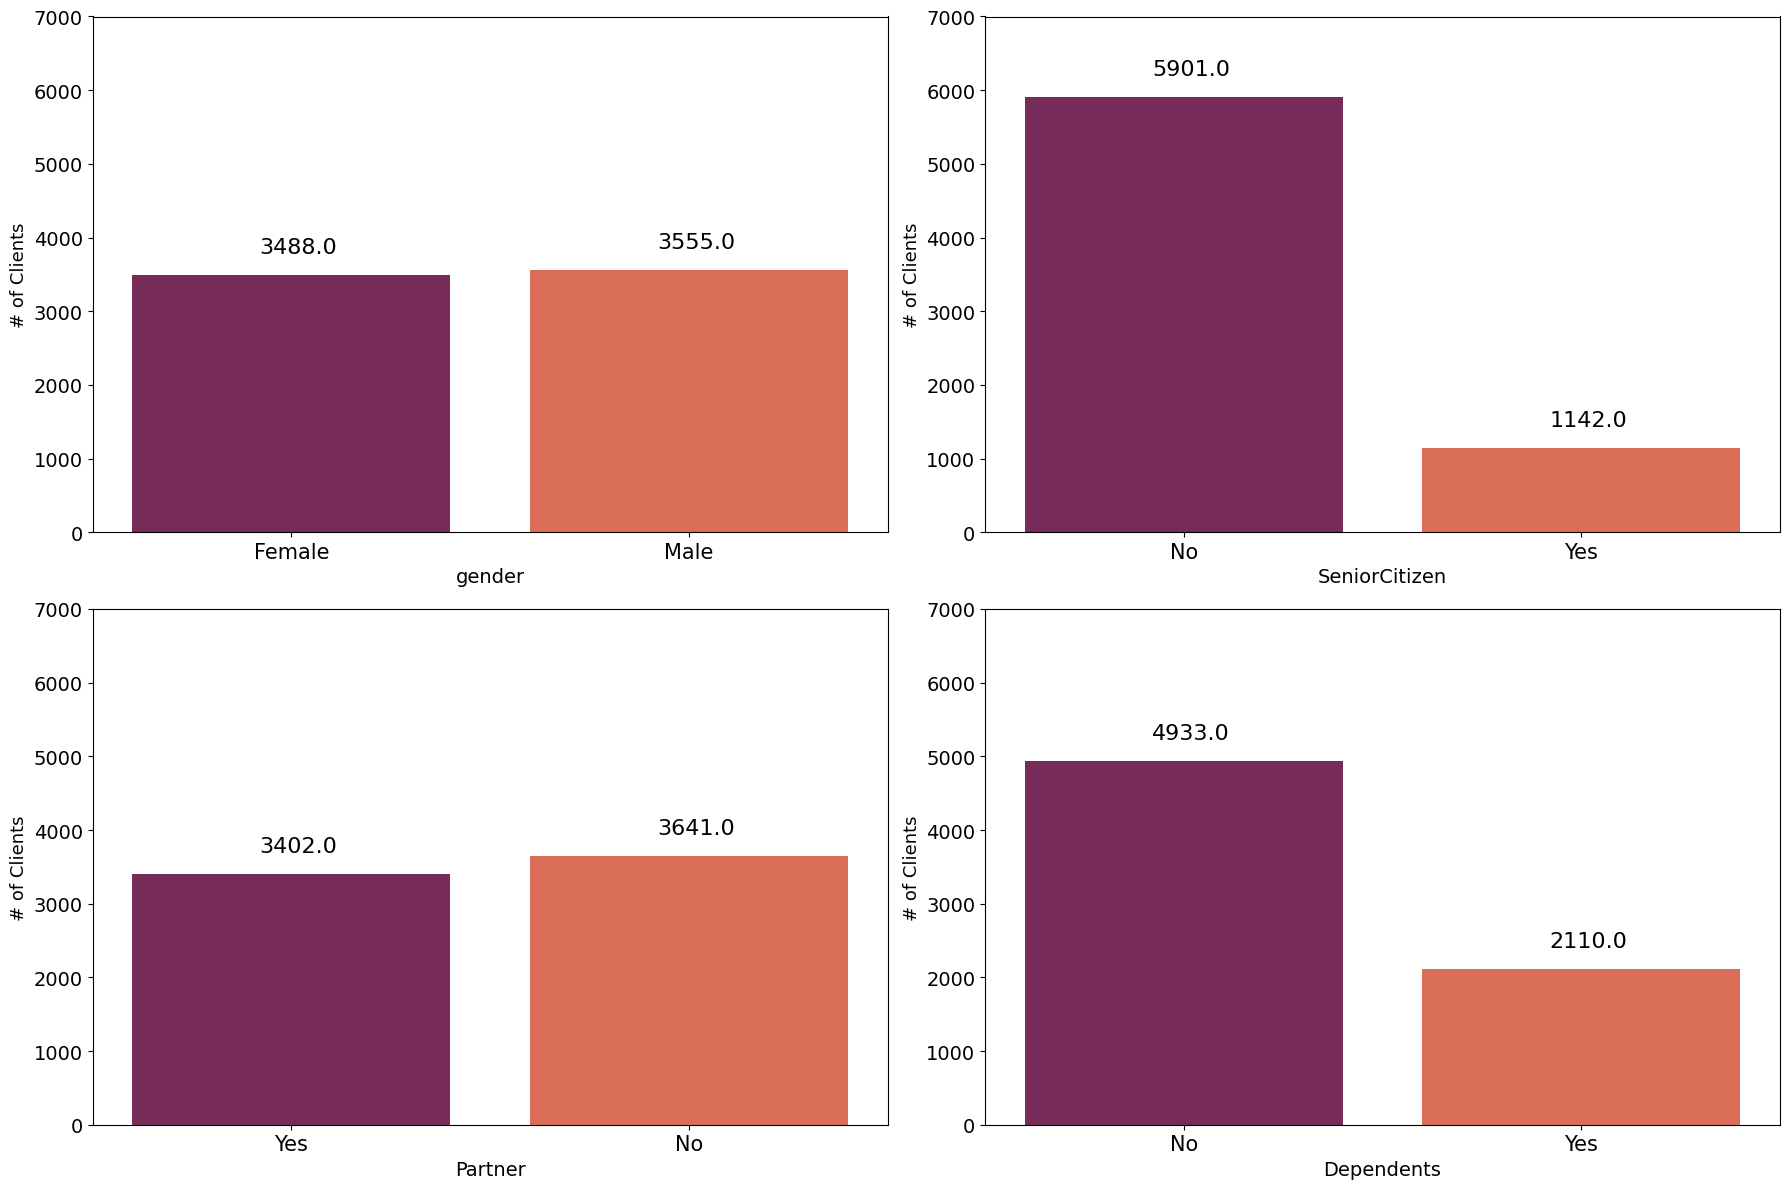

In [20]:
plt.figure(figsize=(18,12))

for i,col in enumerate(demo_features):    
    plt.subplot(2,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7000)
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+300), fontsize= 16)

plt.tight_layout()

plt.show()

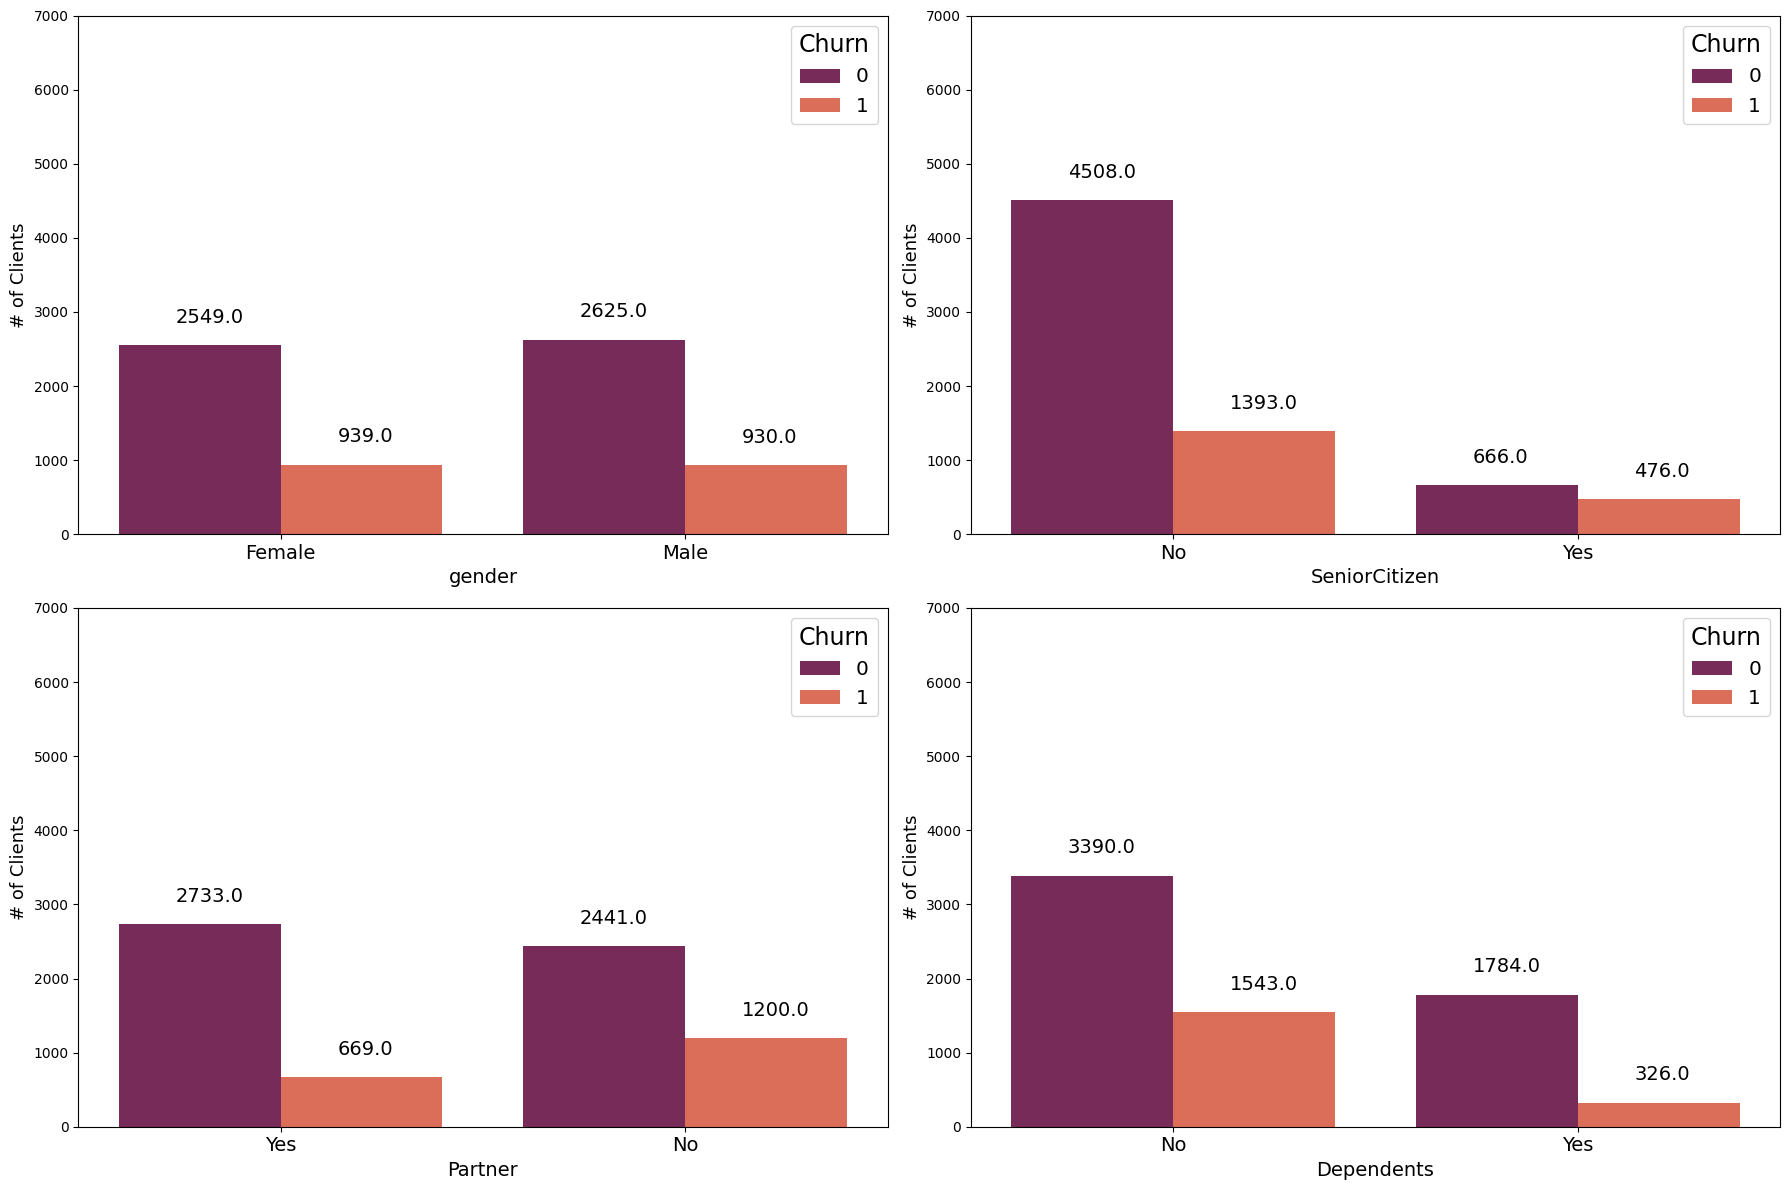

In [21]:
plt.figure(figsize=(18,12))

for i,col in enumerate(demo_features):    
    plt.subplot(2,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn", palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7000)
    plt.xticks(fontsize= 14)
    
    plt.legend(title = 'Churn', fontsize='x-large', title_fontsize='17')
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.14, p.get_height()+300), fontsize= 14)

plt.tight_layout()

plt.show()

What we can observe for each feature:

Gender: There is barely any difference in churn percentage between men and women;
Senior Citizen: The churn percentage for senior customers are above 40%, indicating a high likelihood of churn from that group;
Partner: Single customers are more likely to churn than customers with partners;
Dependents: Customers with dependents are less likely to churn than customers without any dependents.
We could go a little further and combine the two ‘family-related’ features, ‘Partner’ and ‘Dependents’ to see if, in fact, both of them contribute to the chance of customer churn or retention.

It is expected that the majority of customers with dependents are married and, for instance, it could be that the partnership has more influence on the target than the fact that a customer has or hasn’t a child. Although this might be unlikely, by analyzing both features together, we can discard such hypothesis with more confidence.

In [22]:
df.groupby(['Partner'])['Dependents'].value_counts()

Partner  Dependents
No       No            3280
         Yes            361
Yes      Yes           1749
         No            1653
Name: Dependents, dtype: int64

As expected, most customers with dependents also have a partner. Yet, the number of single customers with dependents seems significant enough for us to draw some conclusions about this particular group.

In [23]:
df.groupby(by=['Partner', 'Dependents'])['Churn'].value_counts(normalize = True)

Partner  Dependents  Churn
No       No          0        0.657622
                     1        0.342378
         Yes         0        0.786704
                     1        0.213296
Yes      No          0        0.745917
                     1        0.254083
         Yes         0        0.857633
                     1        0.142367
Name: Churn, dtype: float64

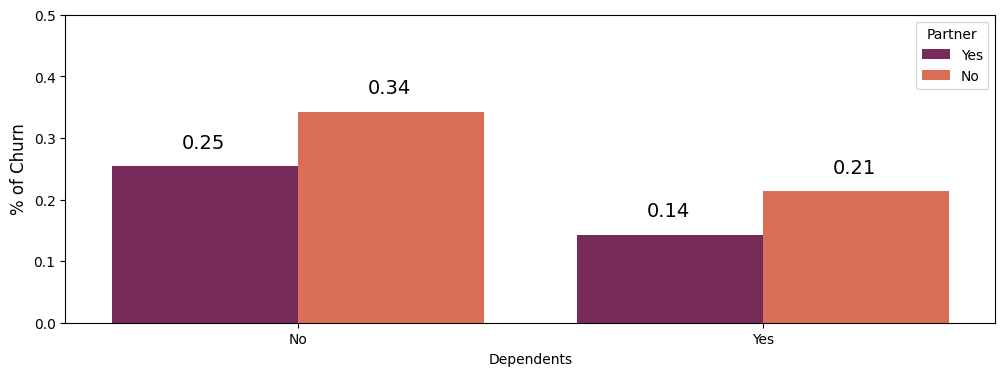

In [24]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "Dependents", y = "Churn", hue = "Partner", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.15, p.get_height()+0.03),fontsize=14)

plt.show()

We can see that both features contribute to the likelihood of churn. The group of people with partners and dependents and the group with neither of those are on the extremes in terms of likelihood of churn (14% and 34%, respectively). The churn of customers with partners and without dependents falls close to the overall percentage of churn in our dataset, while the ‘opposite’ group still have a lower chance of it.

Services Related Features

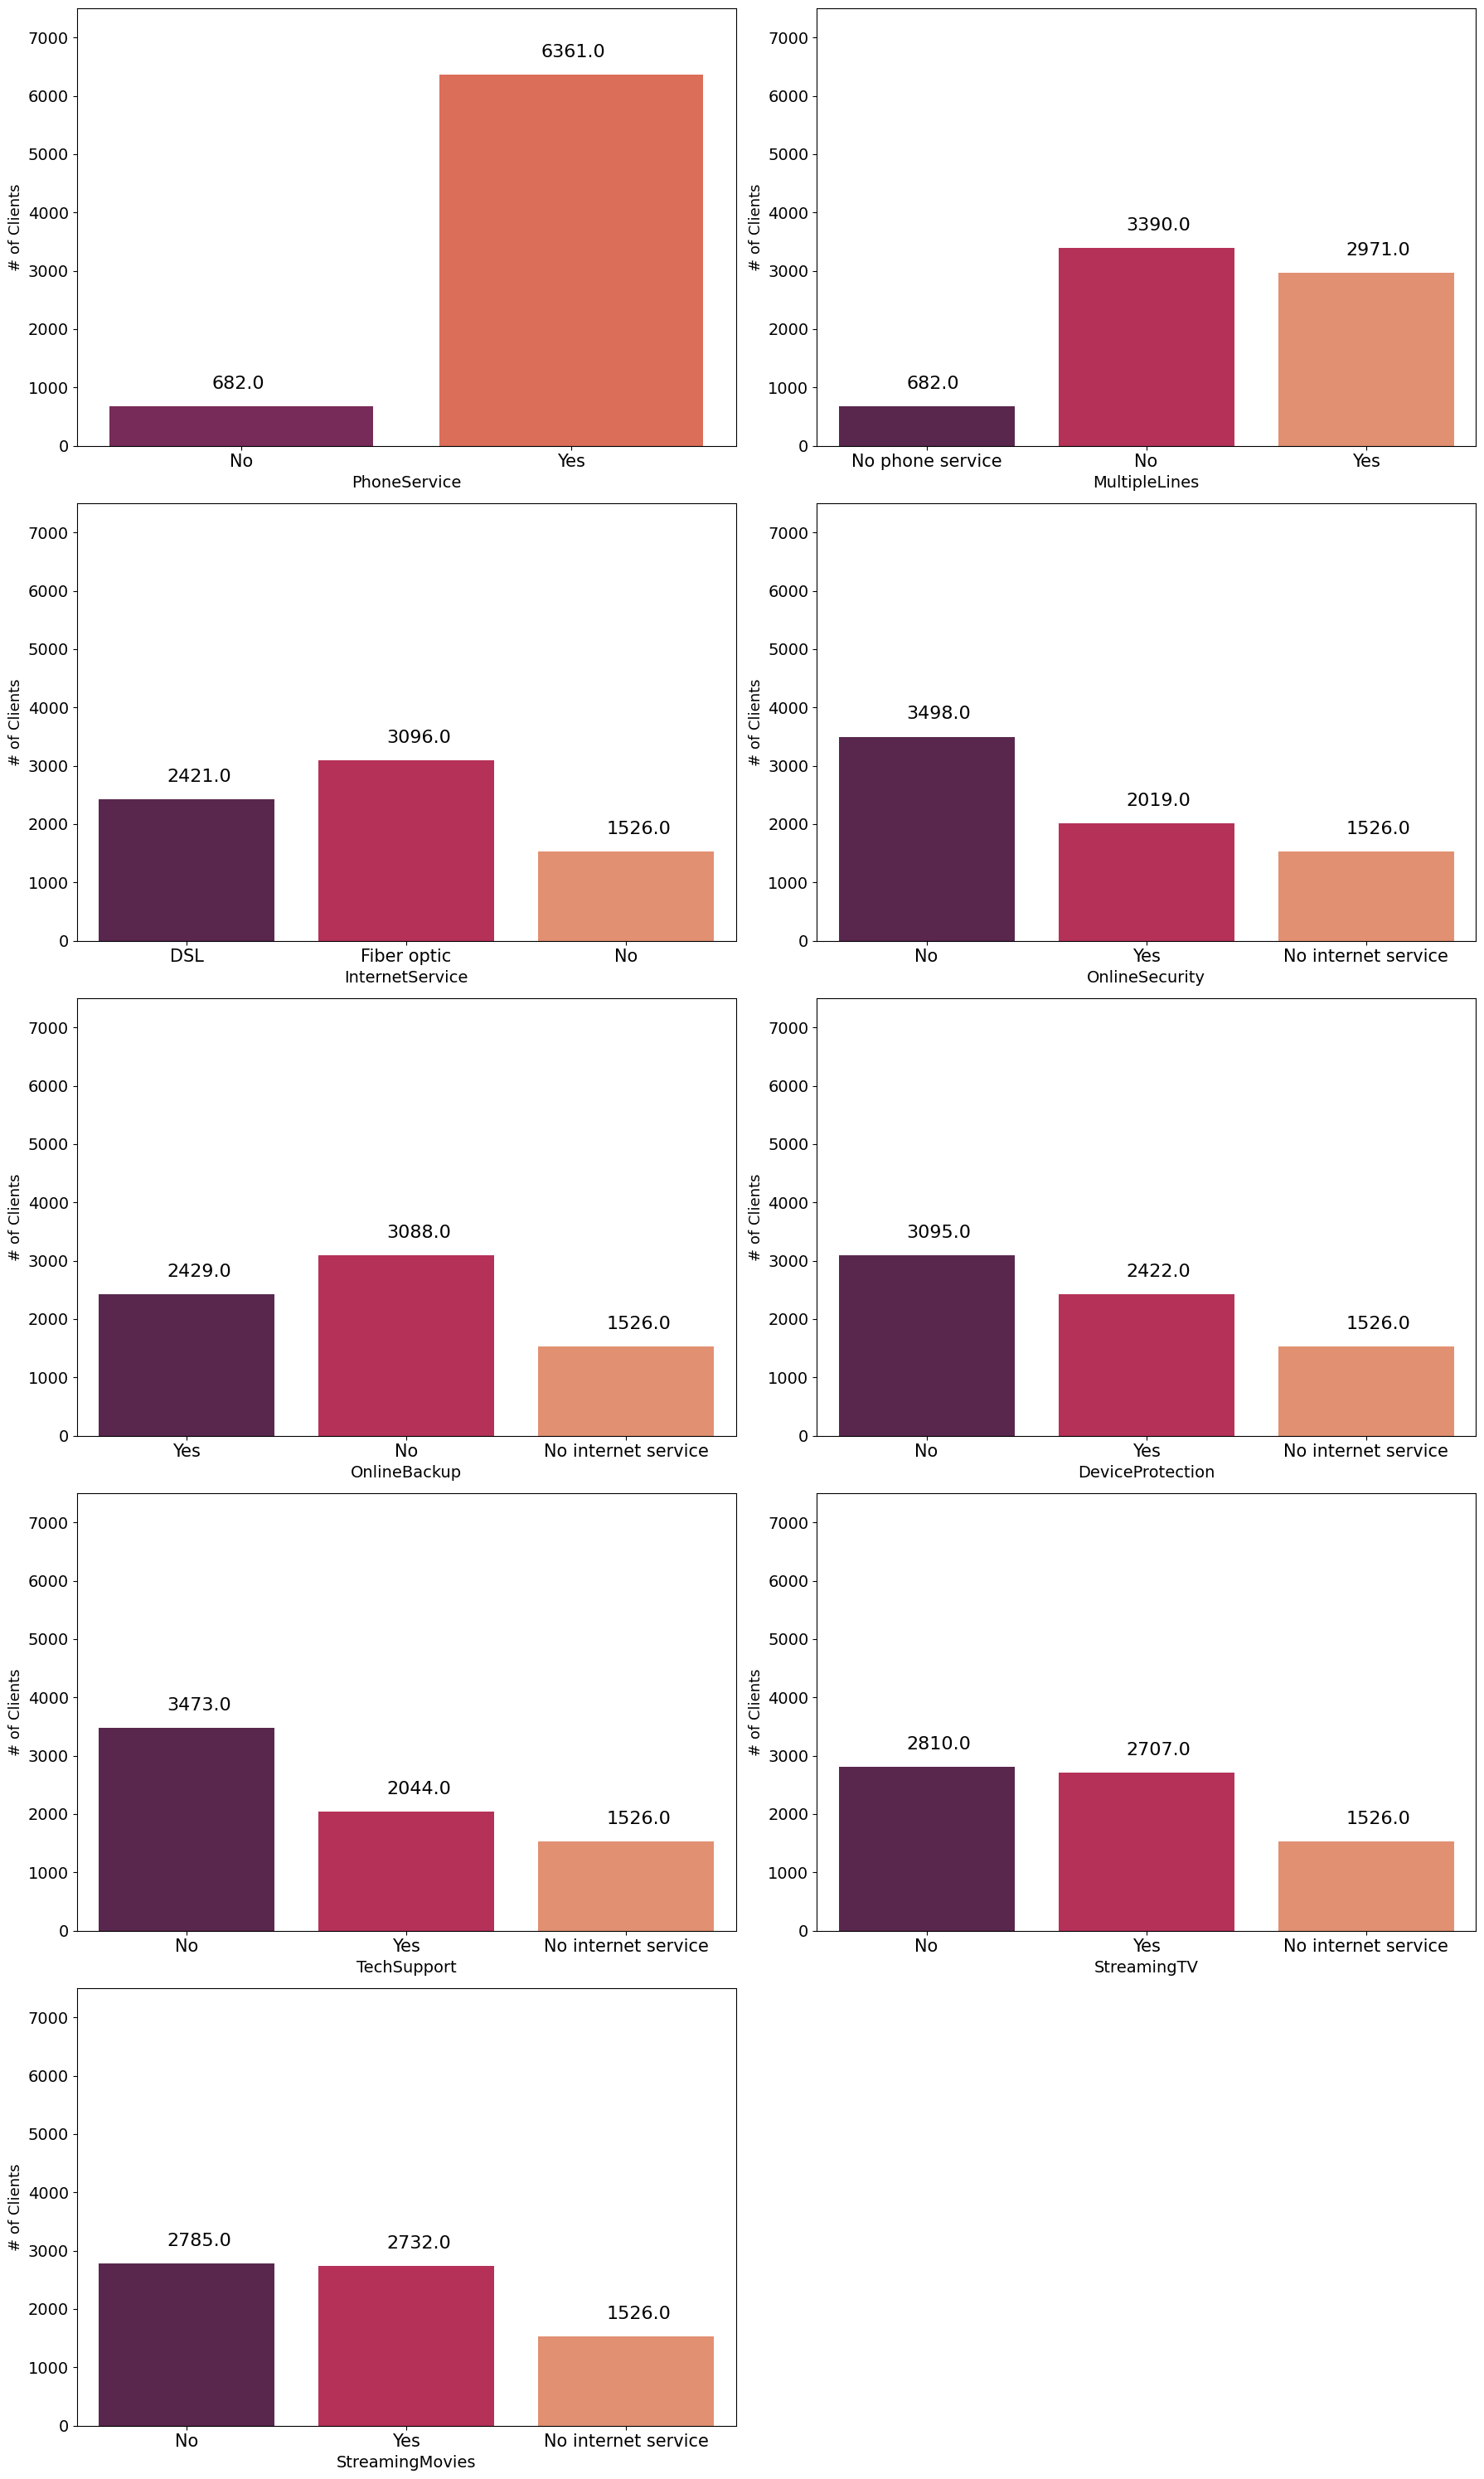

In [25]:
plt.figure(figsize=(18,30))

for i,col in enumerate(serv_features):    
    plt.subplot(5,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7500)
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.31, p.get_height()+300), fontsize= 16)

plt.tight_layout()

plt.show()

A relatively small group of customers doesn’t have internet services and an even smaller one doesn’t have phone services. One thing to keep in mind is that most services can be and/or are only provided to customers who sign the Telco’s internet service.

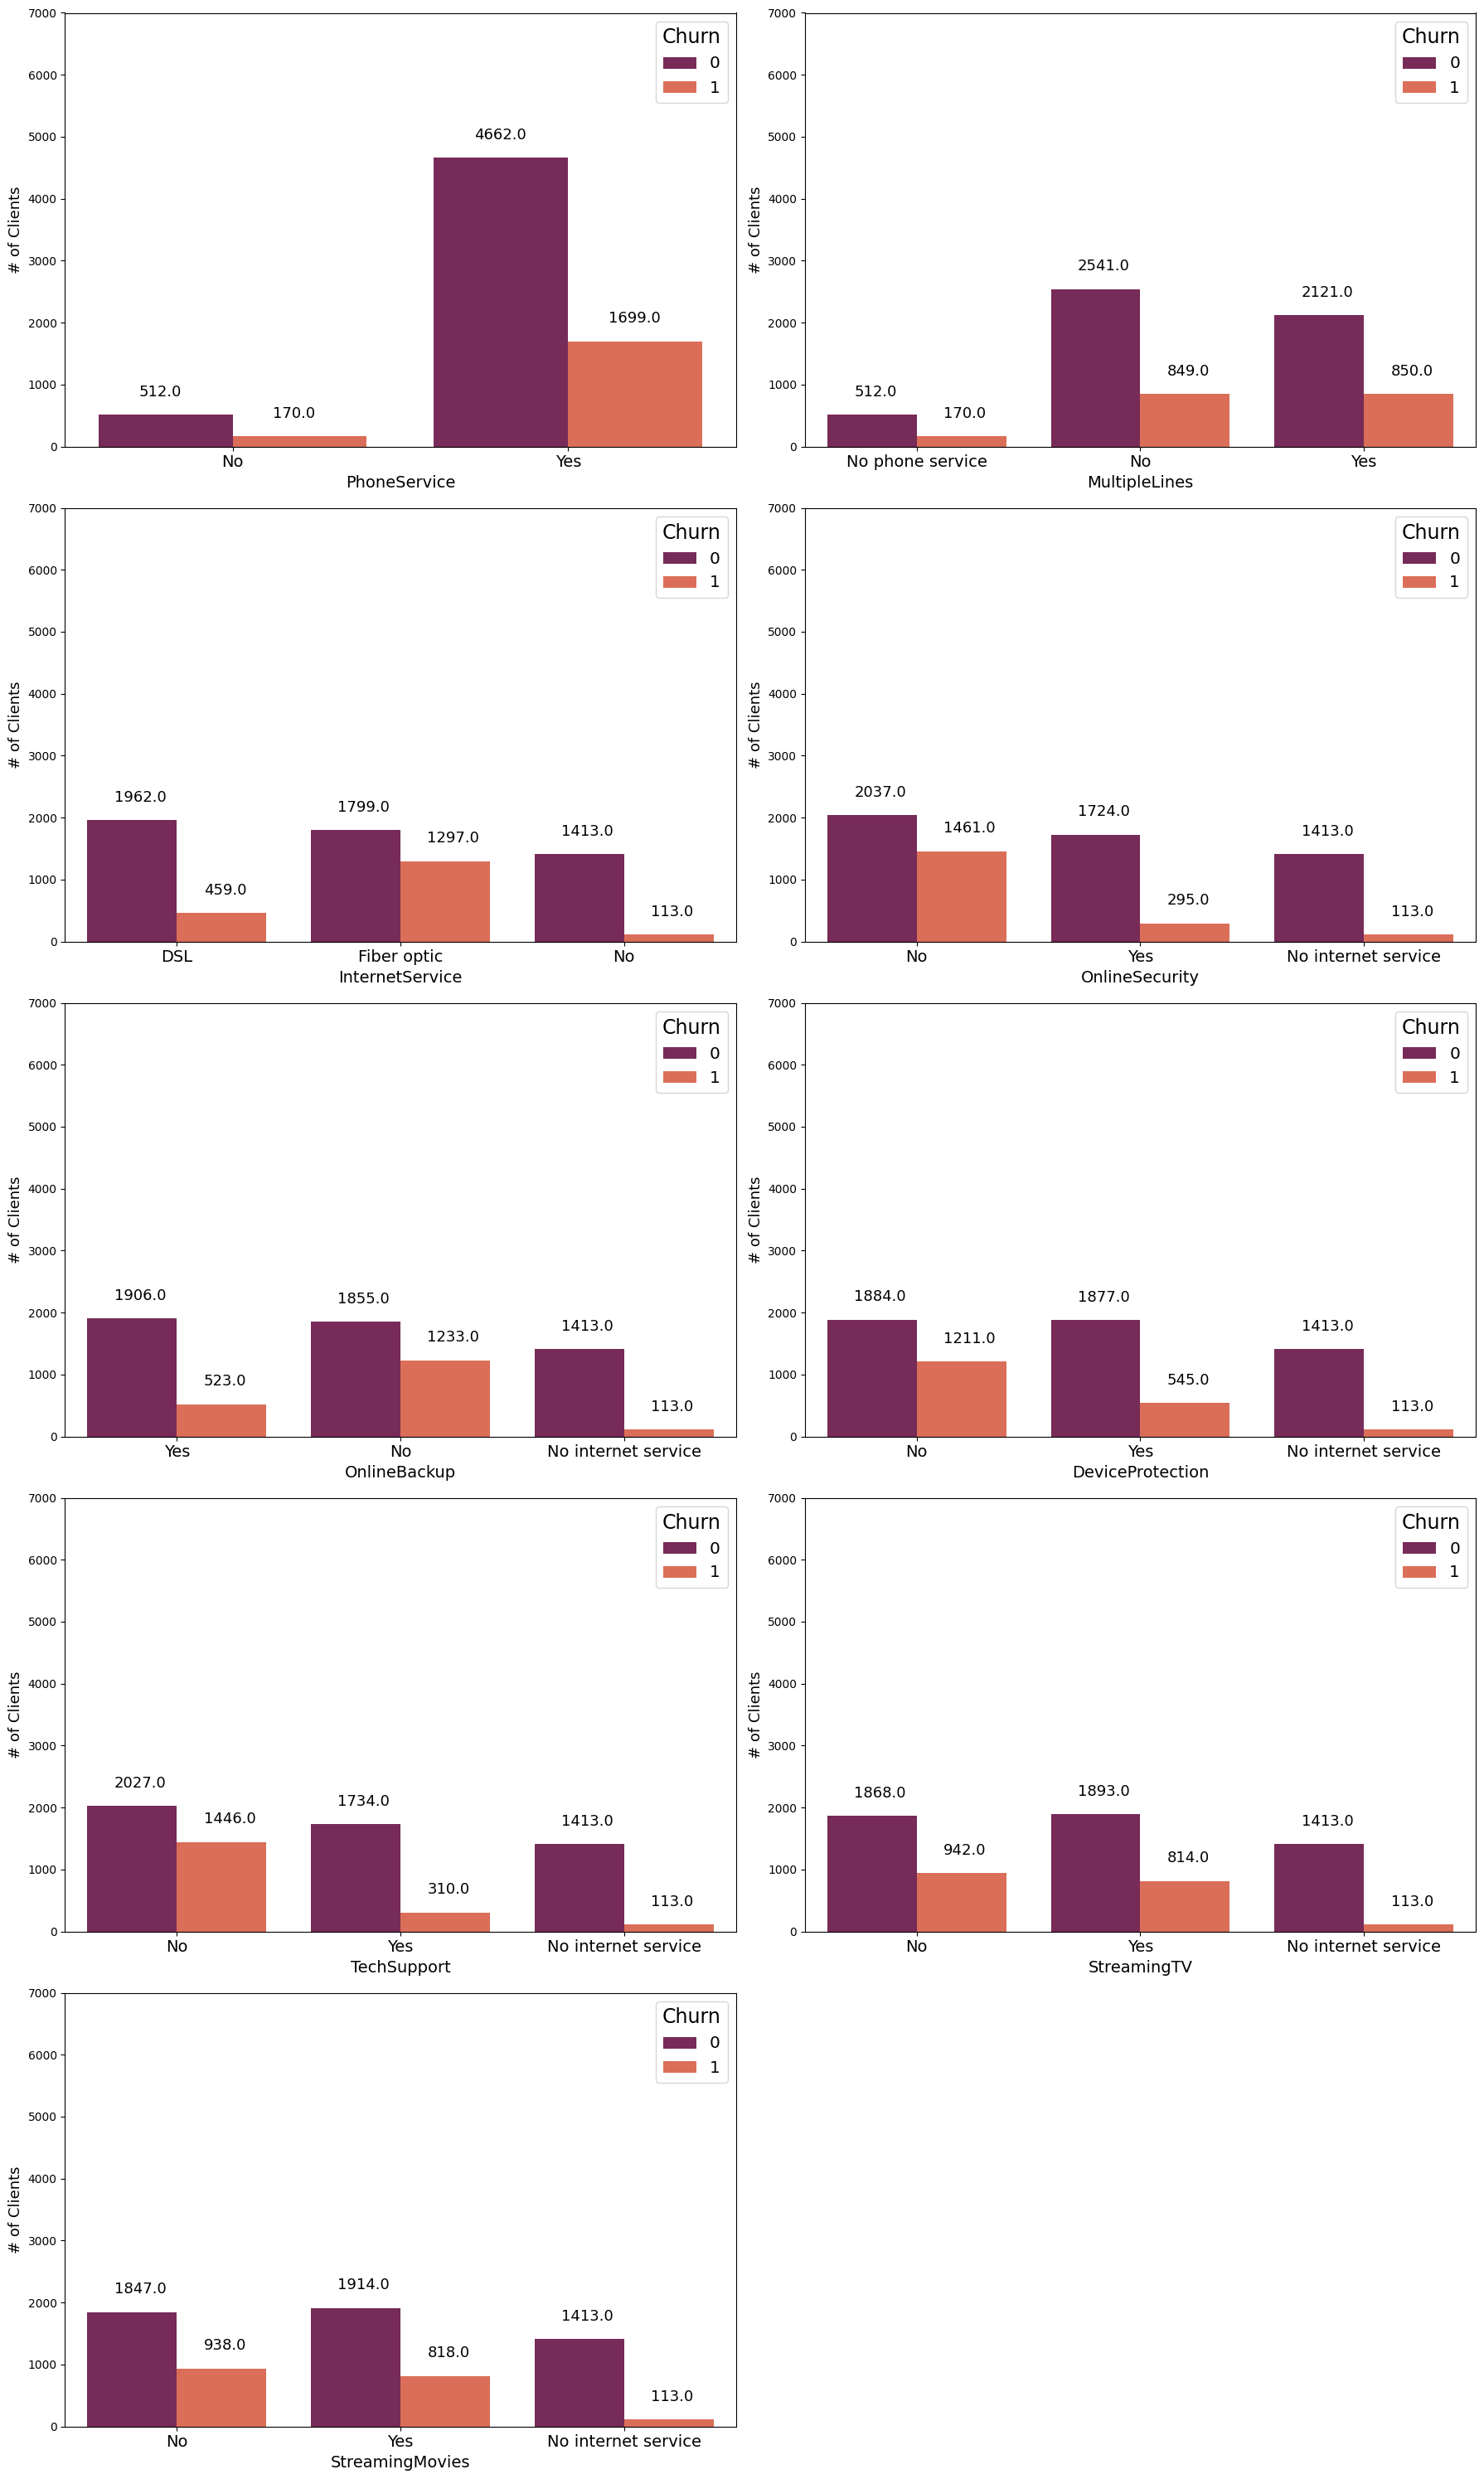

In [26]:
plt.figure(figsize=(18,30))

for i,col in enumerate(serv_features):    
    plt.subplot(5,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn", palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,7000)
    plt.xticks(fontsize= 14)
    
    plt.legend(title = 'Churn', fontsize='x-large', title_fontsize='17')

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.12, p.get_height()+300), fontsize= 13)

plt.tight_layout()

plt.show()

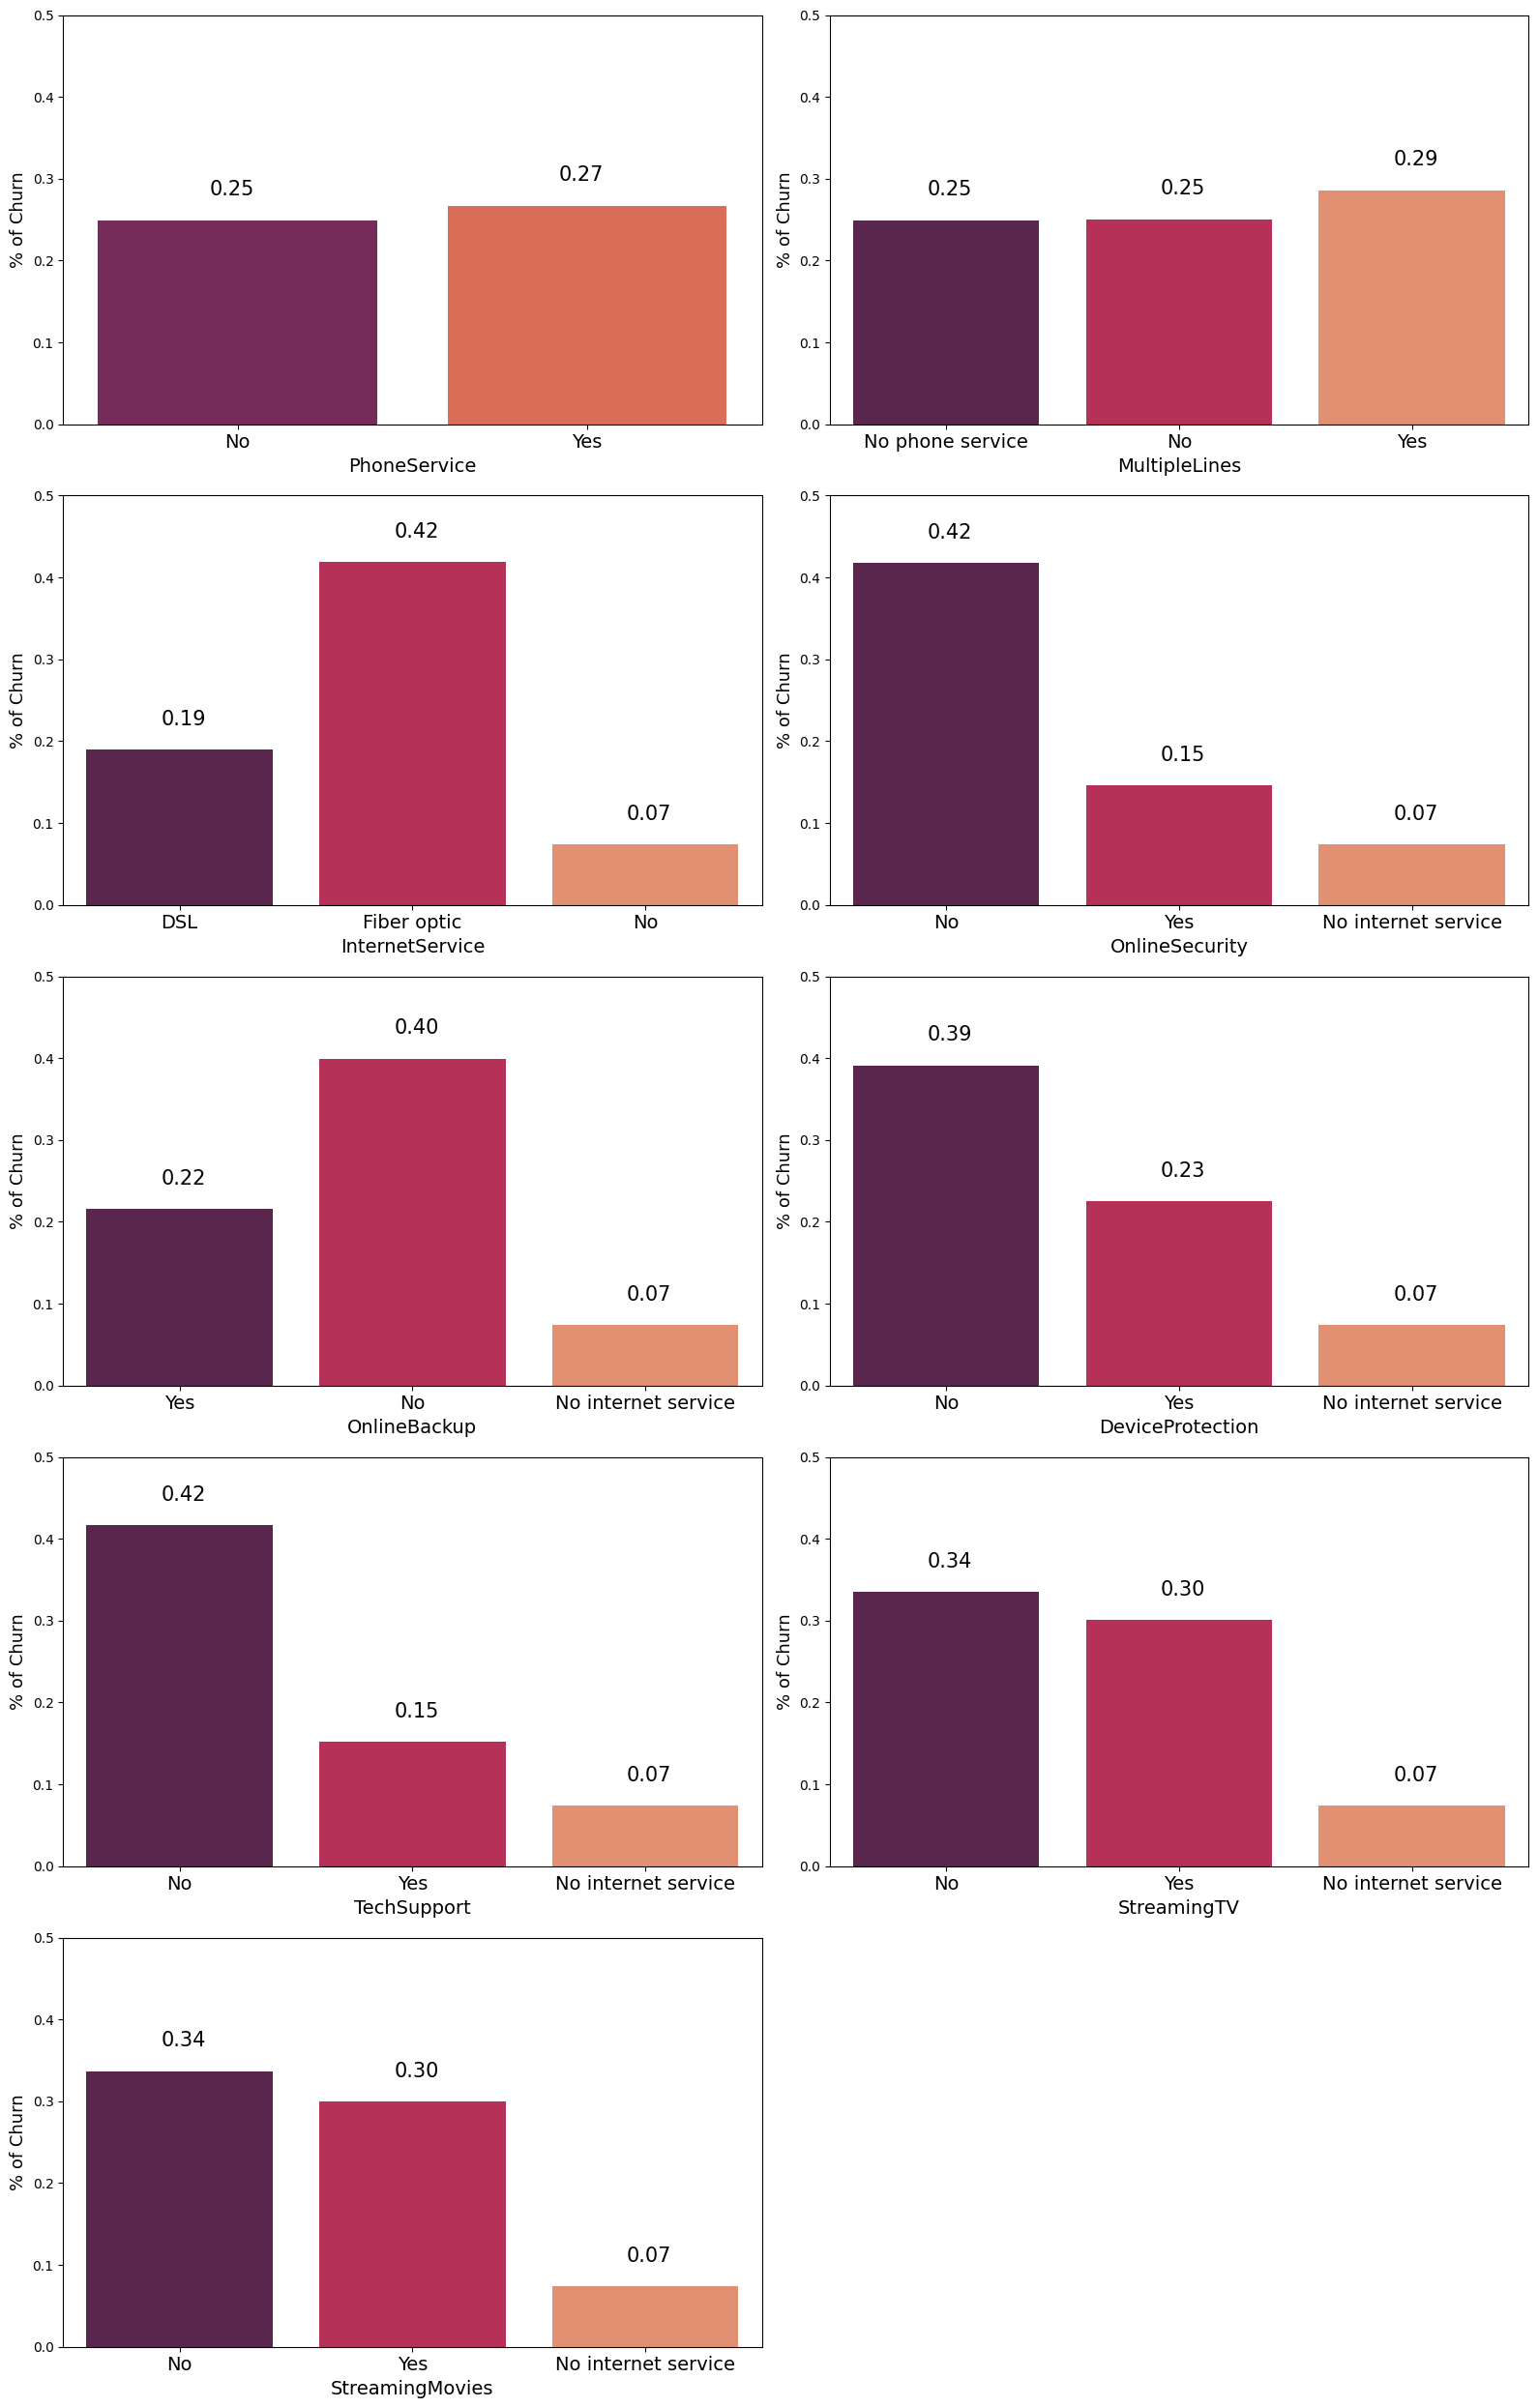

In [27]:
plt.figure(figsize=(16,25))

for i,col in enumerate(serv_features):    
    plt.subplot(5,2,i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df, palette = 'rocket', ci = None)

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("% of Churn", fontsize= 13)
    plt.ylim(0,0.5)
    plt.xticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.32, p.get_height()+0.03),fontsize=15)

plt.tight_layout()

plt.show()

Curiously enough, the difference of churn between clients with and without phone services is quite small, been negligible if we take those with multiple lines out of equation. In this group of features, the real game-changing ones in terms of customer retainment are those related to internet services.

In the feature ‘InternetServices’, the percentage of churn in each category is highly different one from another. Those who don’t subscribe to the company’s internet (presumably, they only use their phone service), are the most likely to endure as their customers. The likelihood of churn from customers with DSL service is also smaller than the overall probability.

The highest percentage of churn, with over 40%, is from customers with fiber optic internet. Fiber optic tends to be faster than DSL internet, but their subscription is usually more expensive as well. We don't have the information about the fee for each service, but at least we can find the mean value of monthly charges per type of internet just to have an idea that this is the case.

In [28]:
df.groupby(by=['InternetService'])['MonthlyCharges'].mean().sort_values()

InternetService
No             21.079194
DSL            58.102169
Fiber optic    91.500129
Name: MonthlyCharges, dtype: float64

As expected, the average charges for each service are significantly different, with fiber optic been the most expensive. Without any additional information, it’s hard to draw definitive conclusions, but it seems that the cost-benefit relationship of their fiber optic service is far from been attractive enough to retain customers.

Such a high churn rate might indicate that their service’s quality is subpar in terms of speed and/or reliability. Analyzing complaints received by their customer service call center service to extract useful and specific information about their internet is a must. A survey with a significant group of customers, aiming to understand how they perceive the quality of the service, is another step to find the problem and to help defining the course of action.

As for the other services, the likelihood of churn from customers who have each one of them is actually lower than from those who haven’t. The higher differences are found in ‘TechSupport’ and ‘OnlineSecurity’, while the lower ones are found in the streaming services.

Let’s calculate the average monthly charges from each category in the Tech Support and Online Security features.

In [29]:
print(df.groupby(by=['TechSupport'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['OnlineSecurity'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['OnlineSecurity', 'TechSupport'])['MonthlyCharges'].mean().sort_values())

TechSupport
No internet service    21.079194
No                     74.586683
Yes                    80.680137
Name: MonthlyCharges, dtype: float64 

OnlineSecurity
No internet service    21.079194
No                     75.693067
Yes                    78.838732
Name: MonthlyCharges, dtype: float64 

OnlineSecurity       TechSupport        
No internet service  No internet service    21.079194
No                   No                     74.188367
Yes                  No                     75.692011
No                   Yes                    79.758148
Yes                  Yes                    81.472930
Name: MonthlyCharges, dtype: float64


Both services don’t seem to affect the subscription charges by much. If the company can quantify the cost of providing each service per customer and find out that it is relatively small, they could either reduce the extra subscription fee for those additional services or simply cut that fee and offer those services as standard for internet customers for a trial period. Given that most customers don’t subscribe to those services and given that they have a significant impact on the customer retainment, it’s possible that such strategy could result in a higher profit on the long term.

Let’s see if the churn rate gets significantly lower for customers who have access to both services.

In [30]:
print(df.groupby(by=['TechSupport'])['OnlineSecurity'].value_counts(), '\n')

TechSupport          OnlineSecurity     
No                   No                     2553
                     Yes                     920
No internet service  No internet service    1526
Yes                  Yes                    1099
                     No                      945
Name: OnlineSecurity, dtype: int64 



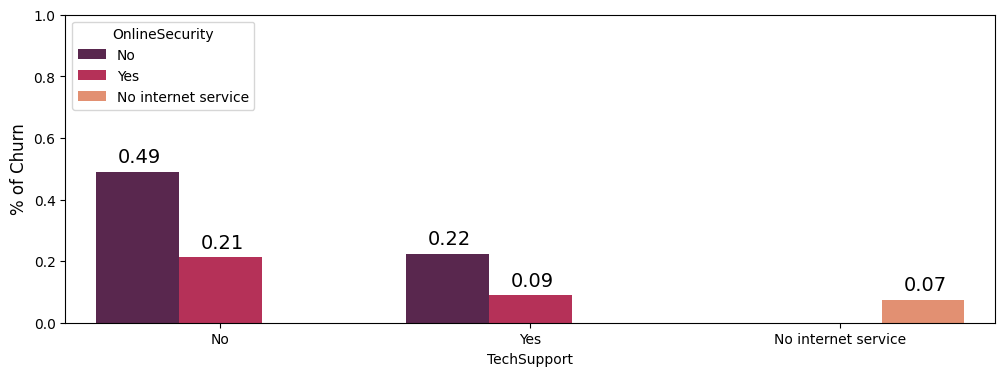

In [31]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "TechSupport", y = "Churn", hue = "OnlineSecurity", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,1.0)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.070, p.get_height()+0.03),fontsize=14)

plt.show()

The differences in terms of churn rate are quite significant. While customers who don’t use neither of those services have a close to 50% chance of churn, the churn rate for those who have both is lower than 10%, supporting the previous point.

Account Information Features (categorical)

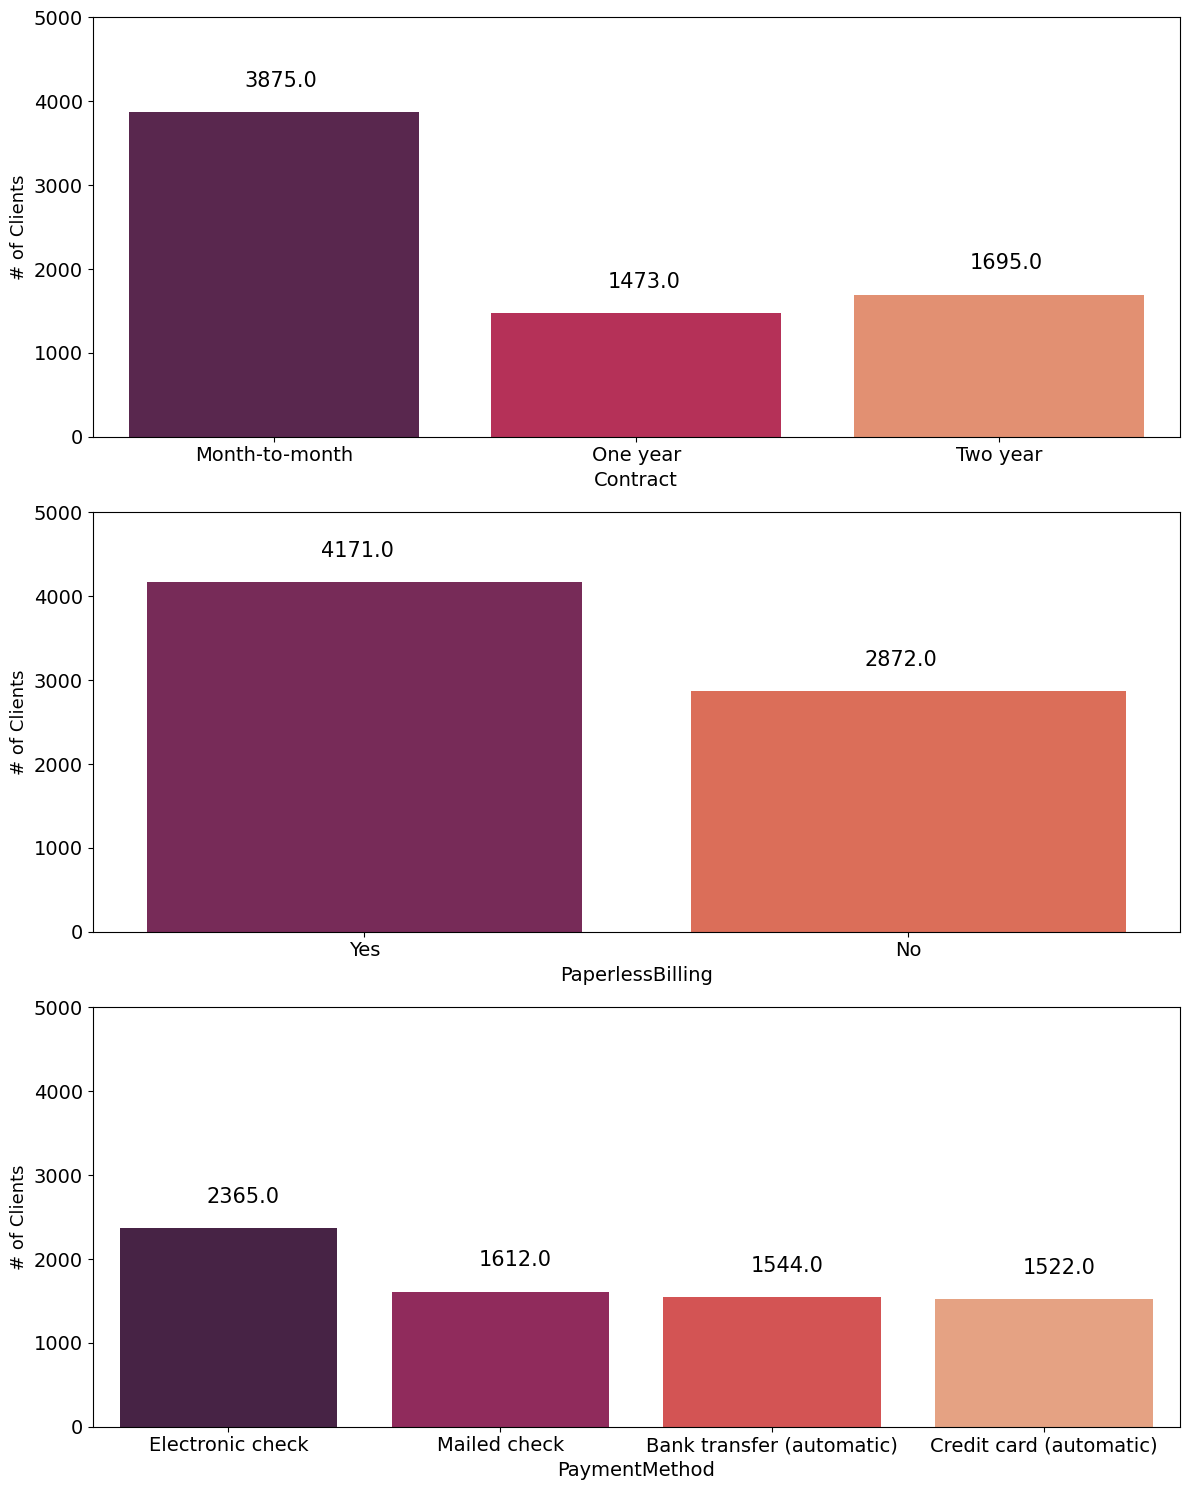

In [32]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.countplot(data = df, x = col, palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,5000)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+300), fontsize= 15)

plt.tight_layout()

plt.show()

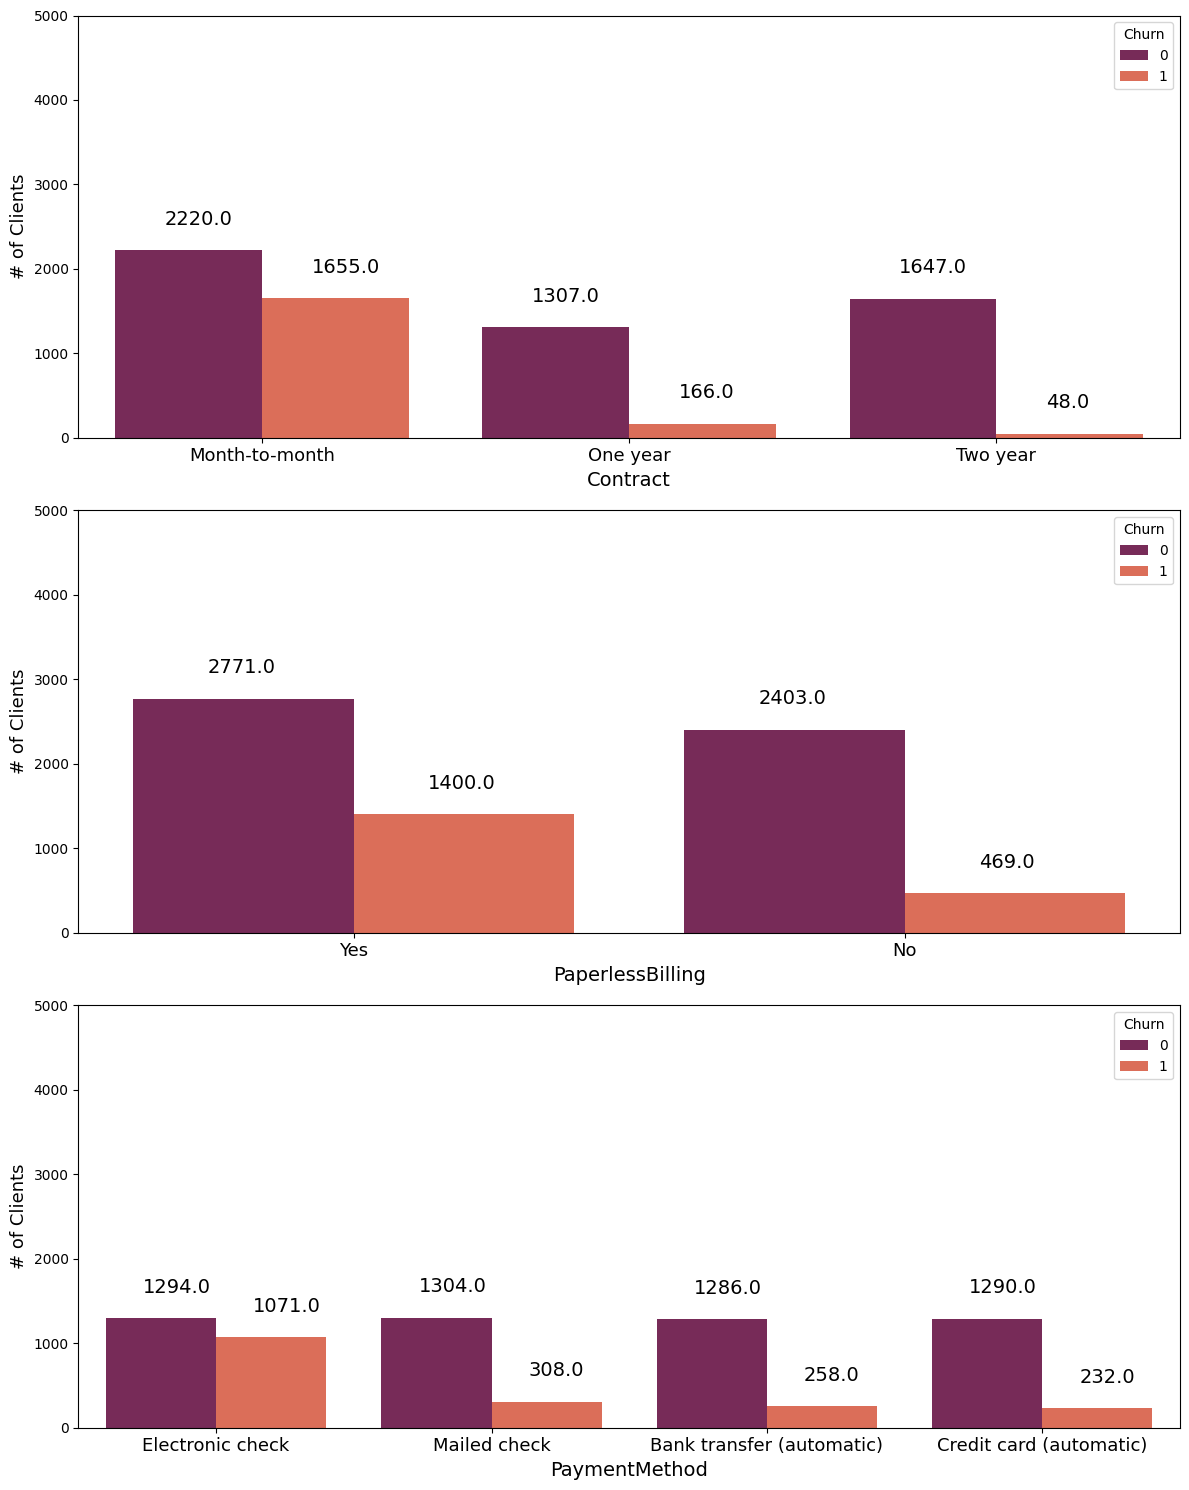

In [33]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn", palette = 'rocket')

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("# of Clients", fontsize= 13)
    plt.ylim(0,5000)
    plt.xticks(fontsize= 13)

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.135, p.get_height()+300), fontsize= 14)

plt.tight_layout()

plt.show()

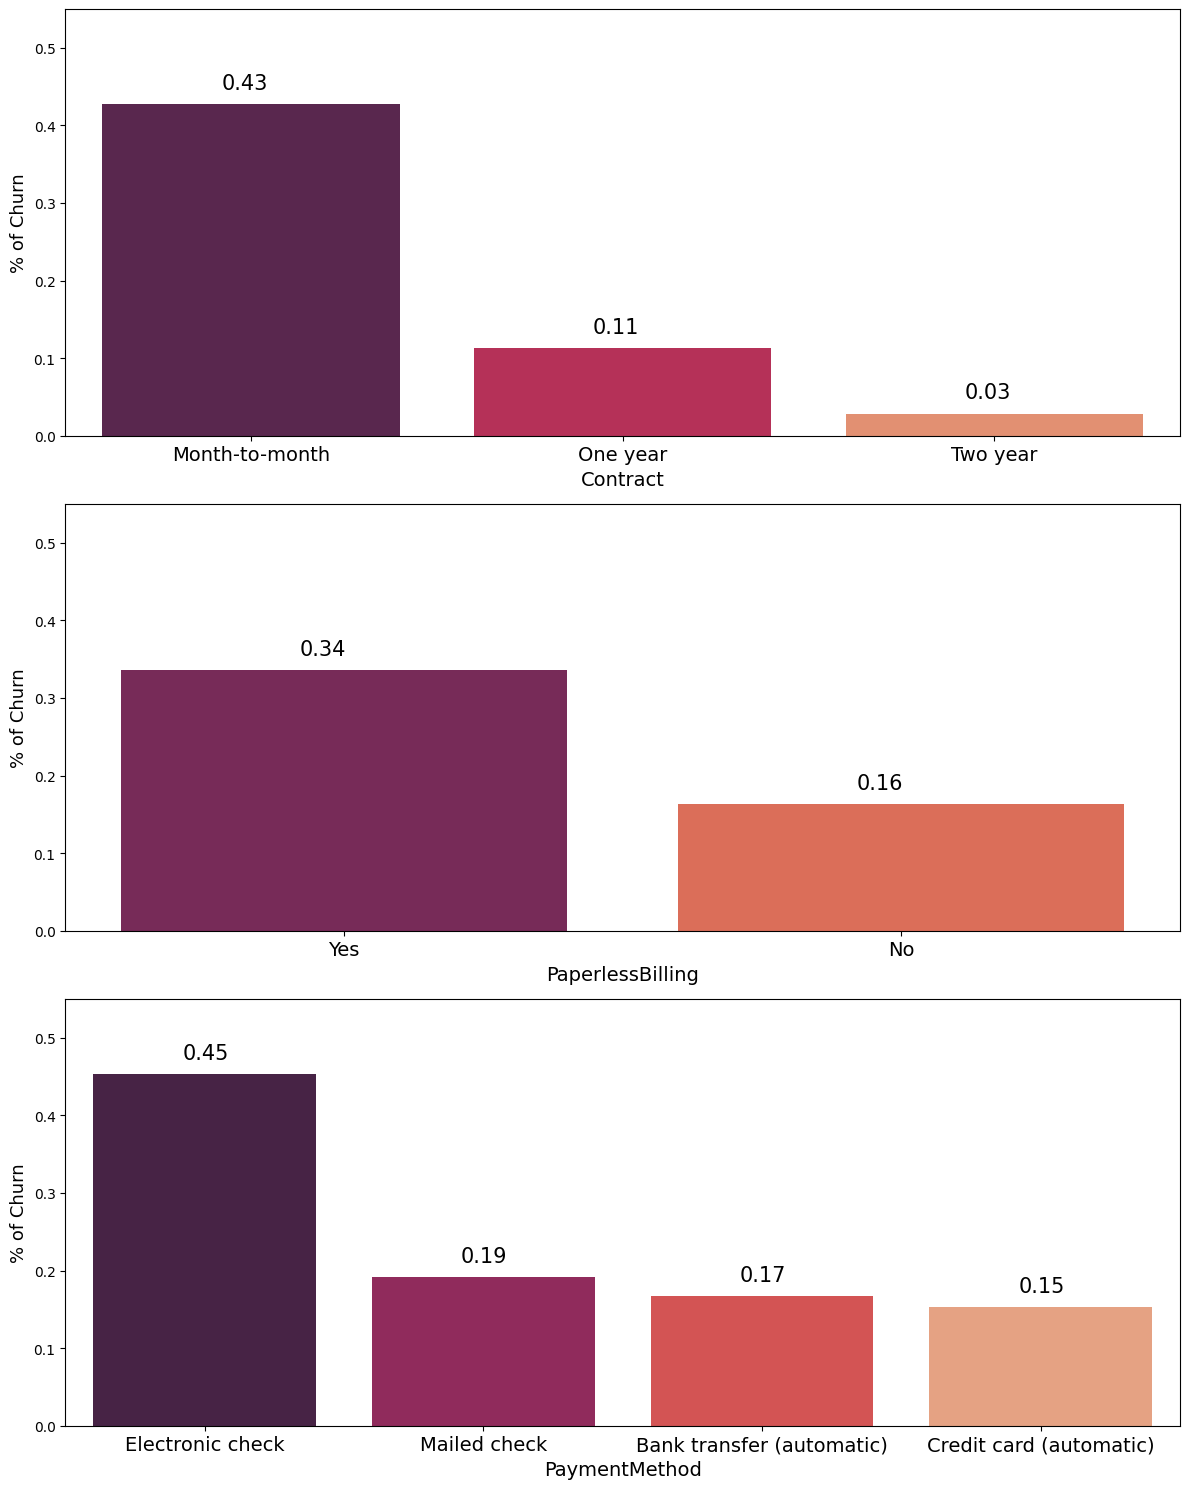

In [34]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df, palette = 'rocket', ci = None)

    plt.xlabel(col, fontsize= 14)
    plt.ylabel("% of Churn", fontsize= 13)
    plt.ylim(0,0.55)
    plt.xticks(fontsize= 14)

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.32, p.get_height()+0.02),fontsize=15)

plt.tight_layout()

plt.show()

Naturally, in terms of contract, the highest churn rate is from the ‘month-to-month’ type, which is also the most dominant contract. What seems odd is the high chance of churn from customers who choose electronic check as payment method and opts for paperless billing. It could be, for instance, that most customers in the month-to-month contract also fall into those categories. We can check that.

In [35]:
print(df.groupby(by=['Contract'])['PaperlessBilling'].value_counts(normalize = True),' \n')
print(df.groupby(by=['Contract'])['PaymentMethod'].value_counts(normalize = True))

Contract        PaperlessBilling
Month-to-month  Yes                 0.667355
                No                  0.332645
One year        Yes                 0.543109
                No                  0.456891
Two year        No                  0.536873
                Yes                 0.463127
Name: PaperlessBilling, dtype: float64  

Contract        PaymentMethod            
Month-to-month  Electronic check             0.477419
                Mailed check                 0.230452
                Bank transfer (automatic)    0.152000
                Credit card (automatic)      0.140129
One year        Credit card (automatic)      0.270197
                Bank transfer (automatic)    0.265445
                Electronic check             0.235574
                Mailed check                 0.228785
Two year        Credit card (automatic)      0.342773
                Bank transfer (automatic)    0.332743
                Mailed check                 0.225369
                Ele

When we group the dataset by contract, we can see that the percentage of customers who don’t receive their bills through the mail and that pay them via electronic check is higher for the ‘month-to-month’ type. Yet, this doesn’t seem to be enough to justify such a high churn rate for those categories. There is a good chance that we will find higher percentages of churn in them, regardless of the type of contract. Let’s see.

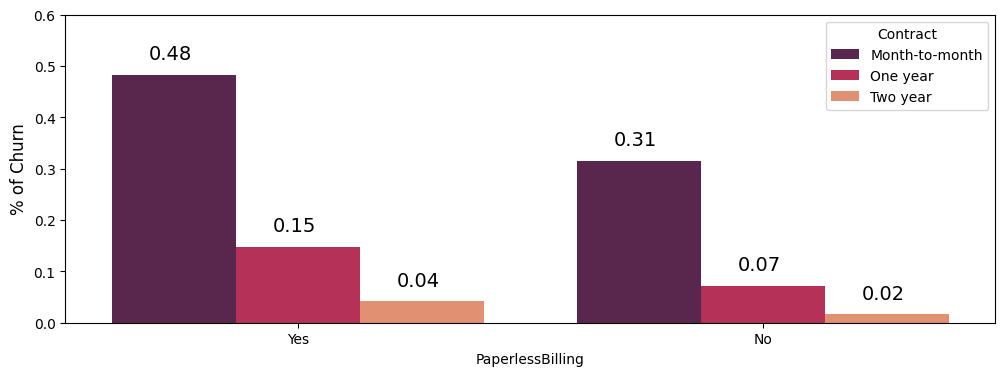

In [36]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "PaperlessBilling", y = "Churn", hue = "Contract", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.6)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.08, p.get_height()+0.03),fontsize=14)

plt.show()

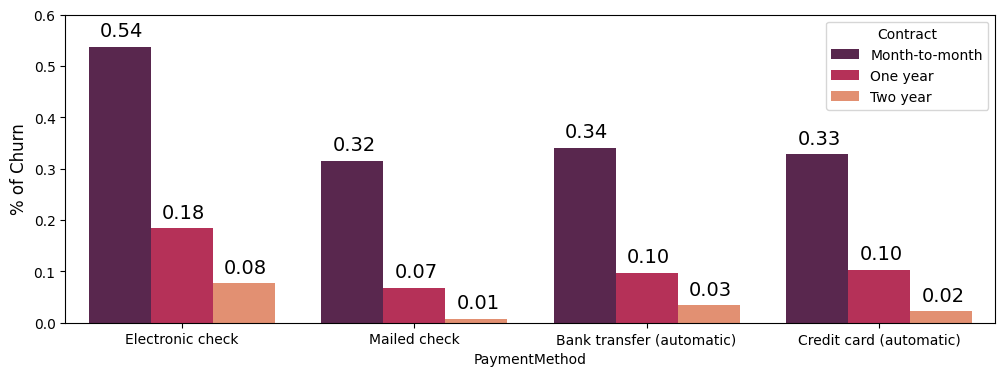

In [37]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "PaymentMethod", y = "Churn", hue = "Contract", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.6)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.05, p.get_height()+0.020),fontsize=14)

plt.show()

The likelihood of churn is, in fact, higher for those categories, regardless of type of contract. Personally, is hard for me to see a causality, without additional information or domain knowledge, between the churn rate and the way someone receives their bill and choose to pay them. It is more likely that those two features are associated with several others. The internet service, a feature with notable differences of churn rate between each one of its categories, could present some correlation between them.

In [38]:
print(df.groupby(by=['InternetService'])['PaperlessBilling'].value_counts(normalize = True), '\n')
print(df.groupby(by=['InternetService'])['PaymentMethod'].value_counts(normalize = True))

InternetService  PaperlessBilling
DSL              Yes                 0.549360
                 No                  0.450640
Fiber optic      Yes                 0.773579
                 No                  0.226421
No               No                  0.707733
                 Yes                 0.292267
Name: PaperlessBilling, dtype: float64 

InternetService  PaymentMethod            
DSL              Electronic check             0.267658
                 Mailed check                 0.253201
                 Credit card (automatic)      0.245353
                 Bank transfer (automatic)    0.233788
Fiber optic      Electronic check             0.515181
                 Bank transfer (automatic)    0.208656
                 Credit card (automatic)      0.192829
                 Mailed check                 0.083333
No               Mailed check                 0.485583
                 Bank transfer (automatic)    0.217562
                 Credit card (automatic)      0.216907
 

What stands out here in our grouping operations:

Customers with Internet Service = ‘No’: Less than 30% receive paperless bills and only 8% pay them with electronic check;
Customers with Internet Service = ‘Fiber Optic’: 77% receive paperless bills and more them 51% pay them with electronic check.
We can recall that the lowest churn rate in the internet services feature is from those customers who don’t use Telco’s internet, while the highest is found among those who use their fiber optic internet. So, we can say that those results don’t come out as a surprise.

Although we shouldn’t conclude that the payment method or the way the bills are sent have a direct influence in the customer retainment, it is worth to point that those features will probably be useful for our prediction models.

Account Information Features (numerical)

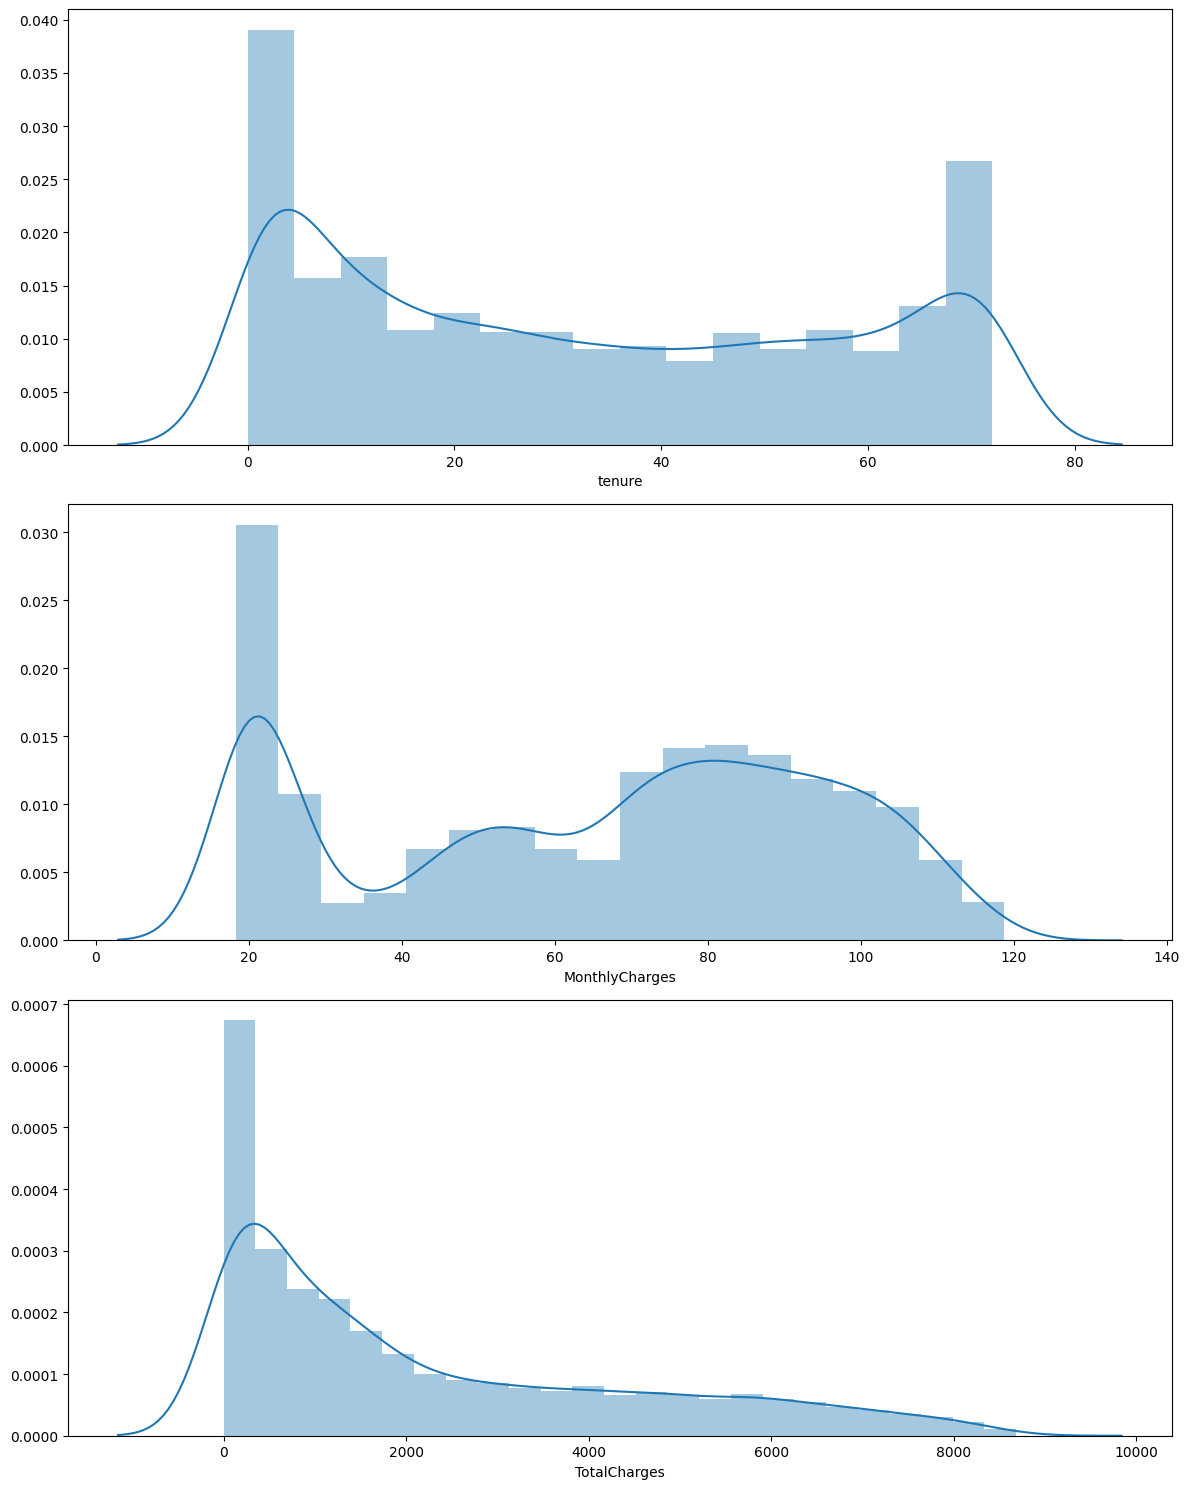

In [39]:
plt.figure(figsize=(12,15))

for i,col in enumerate(num_accinfo_features):    
    plt.subplot(3,1,i + 1)
    sns.distplot(df.loc[:,col])
    #plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation    
    plt.ylabel('')
    plt.tight_layout()

plt.show()

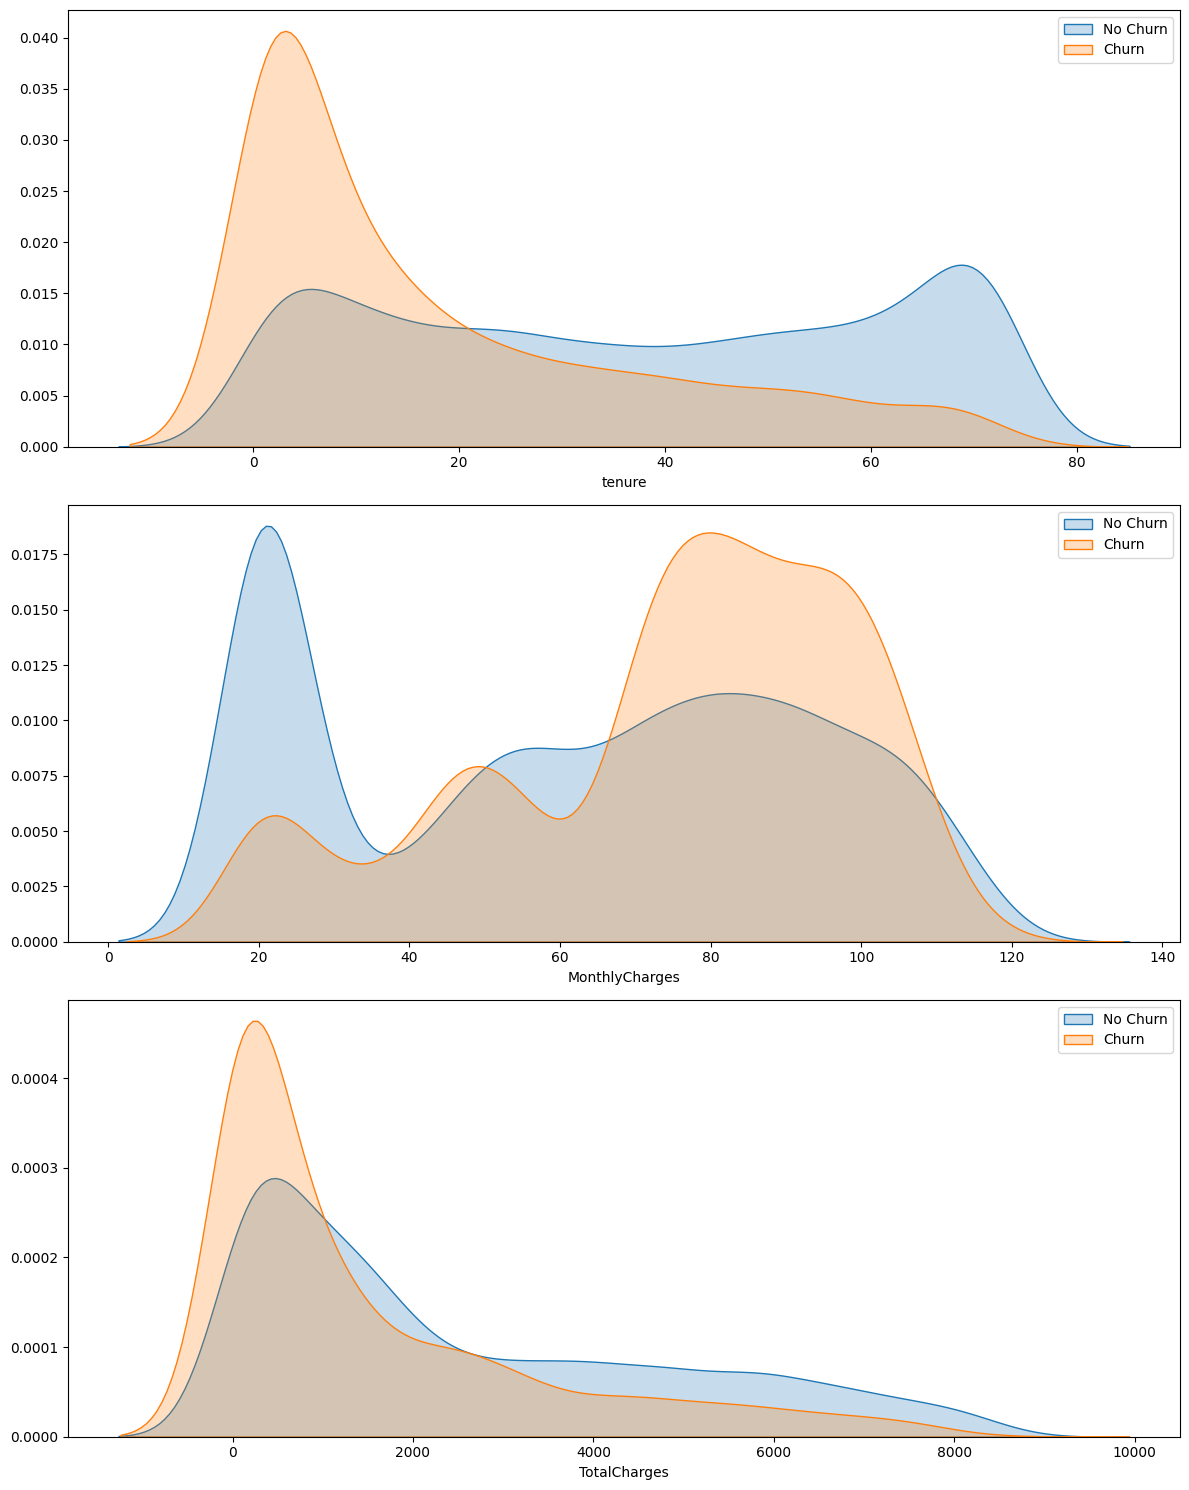

In [40]:
plt.figure(figsize=(12,15))

for i,col in enumerate(num_accinfo_features):    
    plt.subplot(3,1,i + 1)    
    sns.kdeplot(df.loc[(df['Churn'] == 0), col], label = 'No Churn', shade = True)
    sns.kdeplot(df.loc[(df['Churn'] == 1), col], label = 'Churn', shade = True)
    plt.legend()
    plt.ylabel('')
    plt.tight_layout()

plt.show()

What we can observe for each feature:

Tenure: High concentration of churned customer in the first months.
Monthly Charges: High concentration of churned customer in higher values (around 60 and beyond)
Total Charges: Somewhat similar distributions, but the ‘No churn’ distribution have lower values.
Let’s get the mean values to complement our analysis.

In [41]:
print(df.groupby(by=['Churn'])['tenure'].mean().sort_values(), '\n')
print(df.groupby(by=['Churn'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['Churn'])['TotalCharges'].mean().sort_values())

Churn
1    17.979133
0    37.569965
Name: tenure, dtype: float64 

Churn
0    61.265124
1    74.441332
Name: MonthlyCharges, dtype: float64 

Churn
1    1531.796094
0    2549.911442
Name: TotalCharges, dtype: float64


As expected, the average tenure period for churned customers is lower and the average monthly charges are higher than the same metrics for retained customers. The average total charges are lower for churned customers, which is probably due to their lower tenure.

The density plot for churned customers in the ‘tenure’ feature showed a high concentration in the first months. Let’s divide this feature in bins to get the churn rate per year of service.

In [42]:
df['tenure_bin'] = pd.cut(df['tenure'],[-1,12,24,36,48,60,100])
df['tenure_bin'].value_counts(sort = False)

(-1, 12]     2186
(12, 24]     1024
(24, 36]      832
(36, 48]      762
(48, 60]      832
(60, 100]    1407
Name: tenure_bin, dtype: int64

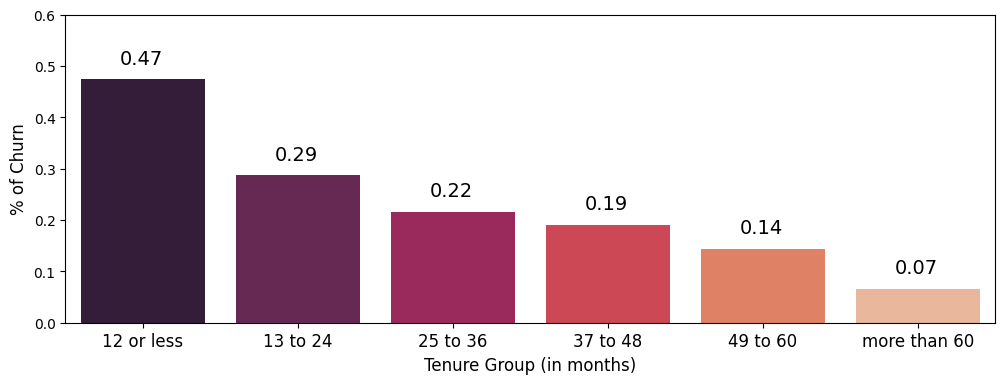

In [43]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "tenure_bin", y = "Churn", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Churn", fontsize= 12)
plt.ylim(0,0.6)
plt.xticks([0,1,2,3,4,5], ['12 or less', '13 to 24', '25 to 36', '37 to 48', '49 to 60', 'more than 60'], fontsize = 12)
plt.xlabel("Tenure Group (in months)", fontsize= 12)



for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=14)

plt.show()

Almost 50 percent of those who became a customer for a year or less ended up leaving the company. It’s not unusual to have a higher churn rate in the first year or two for some types of business. Nevertheless, a churn rate this high in the first year indicates that the quality of the service provided fails to hold up to their new customers’ expectation.

Creating and Evaluating Models

Now, let's move on to the predictive models. In this notebook, we will use the Area Under the Curve of Receiver Characteristic Operator (AUC-ROC or ROC-AUC) as the main metric to assess the performance of our models. The ROC-AUC measures the ability of a model is to distinguish between classes. (Link for more information about ROC-AUC). Nevertheless, we will also check the accuracy and the F1-Score, plus the classification report and the confusion matrix for each model.

First, we will make a copy of the dataset and separate the features from the target.

In [44]:
X = df.copy().drop('Churn', axis = 1)
Y = df['Churn'].copy()

We’re also going to remove the customer_id and the feature ‘tenure_bin’, that we created for EDA purposes, since we’re not planning to use them

In [45]:
X = X.drop(['customerID', 'tenure_bin'], axis = 1)
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


We need to encode the features to use them in our models. We could use something like sklearn’s OrdinalEncoder for this, but I’ll do it manually. This effort will pay off later when we’ll analyze the predictions using SHAP.

In [47]:
gender_map = {'Female': 0, 'Male': 1}
yes_or_no_map = {'No': 0, 'Yes': 1} #seniorcitizen, partner, dependents, phoneservice, paperlessbilling
multiplelines_map = {'No phone service': -1, 'No': 0, 'Yes': 1}
internetservice_map = {'No': -1, 'DSL': 0, 'Fiber optic': 1}
add_netservices_map = {'No internet service': -1, 'No': 0, 'Yes': 1} #onlinesecurity, onlinebackup, deviceprotection,techsupport,streaming services
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
paymentmethod_map = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}


X['gender'] = X['gender'].map(gender_map).astype('int')
X['Partner'] = X['Partner'].map(yes_or_no_map).astype('int')
X['SeniorCitizen'] = X['SeniorCitizen'].map(yes_or_no_map).astype('int')
X['Dependents'] = X['Dependents'].map(yes_or_no_map).astype('int')
X['PhoneService'] = X['PhoneService'].map(yes_or_no_map).astype('int')
X['MultipleLines'] = X['MultipleLines'].map(multiplelines_map).astype('int')
X['InternetService'] = X['InternetService'].map(internetservice_map).astype('int')
X['OnlineSecurity'] = X['OnlineSecurity'].map(add_netservices_map).astype('int')
X['OnlineBackup'] = X['OnlineBackup'].map(add_netservices_map).astype('int')
X['DeviceProtection'] = X['DeviceProtection'].map(add_netservices_map).astype('int')
X['TechSupport'] = X['TechSupport'].map(add_netservices_map).astype('int')
X['StreamingTV'] = X['StreamingTV'].map(add_netservices_map).astype('int')
X['StreamingMovies'] = X['StreamingMovies'].map(add_netservices_map).astype('int')
X['Contract'] = X['Contract'].map(contract_map).astype('int')
X['PaperlessBilling'] = X['PaperlessBilling'].map(yes_or_no_map).astype('int')
X['PaymentMethod'] = X['PaymentMethod'].map(paymentmethod_map).astype('int')

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int32  
 1   SeniorCitizen     7043 non-null   int32  
 2   Partner           7043 non-null   int32  
 3   Dependents        7043 non-null   int32  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int32  
 6   MultipleLines     7043 non-null   int32  
 7   InternetService   7043 non-null   int32  
 8   OnlineSecurity    7043 non-null   int32  
 9   OnlineBackup      7043 non-null   int32  
 10  DeviceProtection  7043 non-null   int32  
 11  TechSupport       7043 non-null   int32  
 12  StreamingTV       7043 non-null   int32  
 13  StreamingMovies   7043 non-null   int32  
 14  Contract          7043 non-null   int32  
 15  PaperlessBilling  7043 non-null   int32  
 16  PaymentMethod     7043 non-null   int32  


Now we will split the data into train and test sets.

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42
                                                    , stratify = Y)

Logistic Regression
The first model we're going to use is Logistic Regression, which will require two things for a better performance:

Scaling the numerical features;
(One hot) encoding the categorical (nominal) features.
We can use the Column Transformer to assign each transformation to its correct features and fit it in a pipeline as a preprocessing step.

In [50]:
num_features = num_accinfo_features

cat_3p_features = []
for col in X.columns:
    if (X[col].nunique() > 2) & (X[col].nunique() < 5):  #less than 5 to exclude the numerical features
        cat_3p_features.append(col)
print('Numerical features: ', num_features, '\n')        
print('Nominal with 3 or more categories: ', cat_3p_features)

Numerical features:  ['tenure', 'MonthlyCharges', 'TotalCharges'] 

Nominal with 3 or more categories:  ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [51]:
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_3p_features)      
    ], remainder='passthrough')

In [52]:
lr_pipe = Pipeline([('Transformers', preprocessor)
                        ,('LR',  LogisticRegression(random_state = 42, max_iter = 1000))])

Even without the intent of doing an extensive hyperparameter tuning, we can give each model a better chance of good performance by testing some values for a key parameter and choosing one of them based on cross-validation score.

In [53]:
def cv_function (model, param, list):
    
    rp_st_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state = 42)
    search_model = model
    print ('Hyperparameter: ', param)
    
    for i in list:
        param_dict = {param : i}
        search_model.set_params(**param_dict)    
        cv_score = cross_val_score(search_model, X_train, Y_train, cv=rp_st_kfold, scoring='roc_auc')
        print("Parameter: {0:0.2f} - AUC(SD): {1:0.4f} ({2:0.4f})". format(i, cv_score.mean(), cv_score.std()))
        
params_lr_list = [0.01,0.1,0.2,0.3,0.5,0.7,1,2,3,5]
param_lr = 'LR__C'
cv_function(lr_pipe, param_lr, params_lr_list)

Hyperparameter:  LR__C
Parameter: 0.01 - AUC(SD): 0.8435 (0.0142)
Parameter: 0.10 - AUC(SD): 0.8456 (0.0144)
Parameter: 0.20 - AUC(SD): 0.8459 (0.0144)
Parameter: 0.30 - AUC(SD): 0.8460 (0.0144)
Parameter: 0.50 - AUC(SD): 0.8461 (0.0144)
Parameter: 0.70 - AUC(SD): 0.8462 (0.0144)
Parameter: 1.00 - AUC(SD): 0.8463 (0.0144)
Parameter: 2.00 - AUC(SD): 0.8463 (0.0144)
Parameter: 3.00 - AUC(SD): 0.8464 (0.0143)
Parameter: 5.00 - AUC(SD): 0.8464 (0.0144)


After some point, there is barely an improvement. Choice: C = 3.0

In [54]:
lr_param = {'LR__C': 3.0}
lr_pipe.set_params(**lr_param) 
lr_pipe

Pipeline(steps=[('Transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('LR',
                 LogisticRegression(C=3.0, max_iter=1000, random_state=42))])

In [55]:
Pipeline(steps=[('Transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('LR',
                 LogisticRegression(C=3.0, max_iter=1000, random_state=42))])

Pipeline(steps=[('Transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('LR',
                 LogisticRegression(C=3.0, max_iter=1000, random_state=42))])

Now, let’s fit this model and predict.

In [56]:
lr_pipe.fit(X_train, Y_train)
pred_lr = lr_pipe.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_lr))
print("Test F1 Score: ",metrics.f1_score(Y_test, pred_lr))

Test Accuracy:  0.8069552874378992
Test F1 Score:  0.6080691642651298


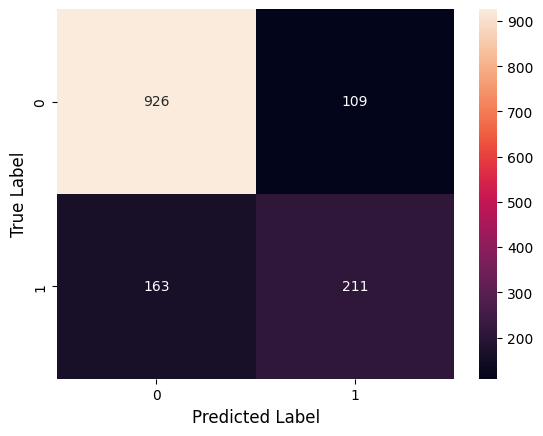

In [57]:
lr_confusion_matrix = metrics.confusion_matrix(Y_test, pred_lr)
sns.heatmap(lr_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [58]:
print(metrics.classification_report(Y_test, pred_lr, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



ROC_AUC:  0.8417473972461184


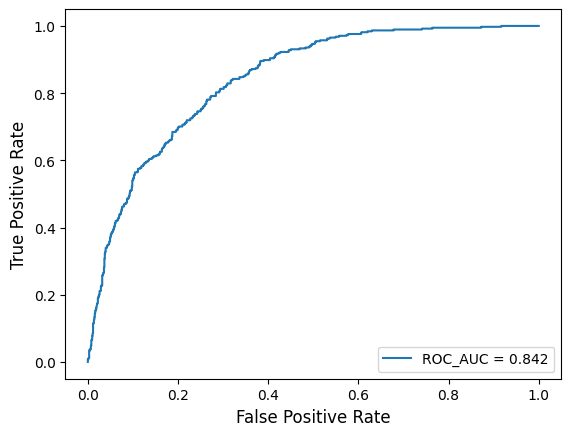

In [59]:
lr_pred_proba = lr_pipe.predict_proba(X_test)[:,1]

lr_roc_auc = metrics.roc_auc_score(Y_test, lr_pred_proba)
print('ROC_AUC: ', lr_roc_auc)

lr_fpr, lr_tpr, thresholds = metrics.roc_curve(Y_test, lr_pred_proba)

plt.plot(lr_fpr,lr_tpr, label = 'ROC_AUC = %0.3f' % lr_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

Random Forest

For every model, we’re going to follow the same steps that we made with Logistic Regression, with the exception of using a pipeline for preprocessing.

In [60]:
rf_model = RandomForestClassifier(random_state = 42)

params_rf_list = [100,150,200,250,300,400,500]
param_rf = 'n_estimators'
cv_function(rf_model, param_rf, params_rf_list)

Hyperparameter:  n_estimators
Parameter: 100.00 - AUC(SD): 0.8262 (0.0155)
Parameter: 150.00 - AUC(SD): 0.8276 (0.0160)
Parameter: 200.00 - AUC(SD): 0.8284 (0.0161)
Parameter: 250.00 - AUC(SD): 0.8288 (0.0161)
Parameter: 300.00 - AUC(SD): 0.8293 (0.0161)
Parameter: 400.00 - AUC(SD): 0.8295 (0.0162)
Parameter: 500.00 - AUC(SD): 0.8297 (0.0162)


In [62]:
rf_param = {'n_estimators': 500}
rf_model.set_params(**rf_param) 
rf_model

RandomForestClassifier(n_estimators=500, random_state=42)

In [63]:
RandomForestClassifier(n_estimators=500, random_state=42)

RandomForestClassifier(n_estimators=500, random_state=42)

In [64]:
rf_model.fit(X_train, Y_train)
pred_rf = rf_model.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_rf))
print("Test F1 Score: ",metrics.f1_score(Y_test, pred_rf))

Test Accuracy:  0.7877927608232789
Test F1 Score:  0.5543964232488823


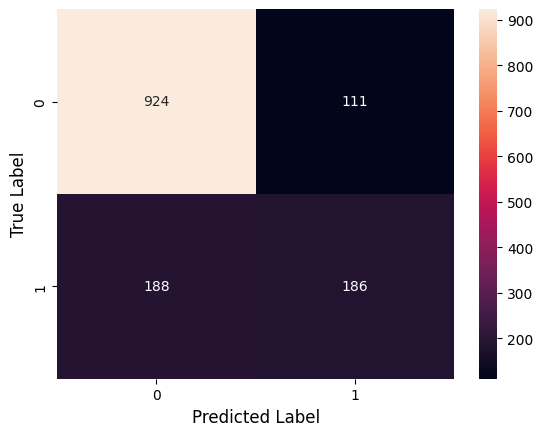

In [65]:
rf_confusion_matrix = metrics.confusion_matrix(Y_test, pred_rf)
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [66]:
print(metrics.classification_report(Y_test, pred_rf, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



ROC_AUC:  0.8251013976077916


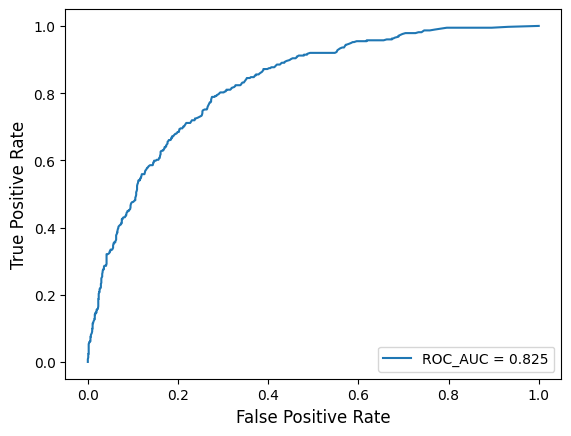

In [67]:
rf_pred_proba = rf_model.predict_proba(X_test)[:,1]

rf_roc_auc = metrics.roc_auc_score(Y_test, rf_pred_proba)
print('ROC_AUC: ', rf_roc_auc)

rf_fpr, rf_tpr, thresholds = metrics.roc_curve(Y_test, rf_pred_proba)

plt.plot(rf_fpr,rf_tpr, label = 'ROC_AUC = %0.3f' % rf_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The results we found with Random Forest were quite disappointing. Although feature scaling and one hot encoding aren’t necessary, we can use them just for testing purposes.

Random Forest with Preprocessing

In [68]:
rf_pipe = Pipeline([('Transformers', preprocessor)
                        ,('RF',  RandomForestClassifier(n_estimators = 500, random_state = 42))])

rf_pipe.fit(X_train, Y_train)
pred_rf_pipe = rf_pipe.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_rf_pipe))
print("Test F1 Score: ",metrics.f1_score(Y_test, pred_rf_pipe))

Test Accuracy:  0.7799858055358411
Test F1 Score:  0.5454545454545455


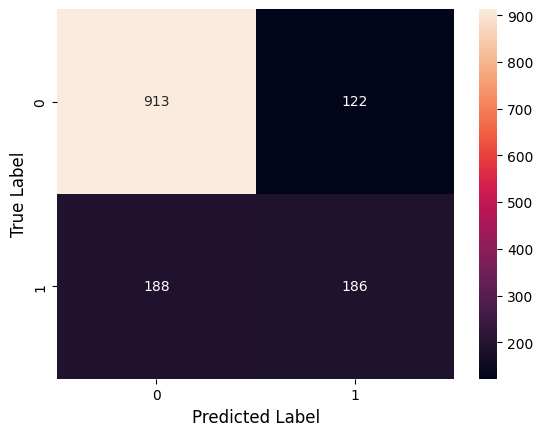

In [69]:
rf_pipe_confusion_matrix = metrics.confusion_matrix(Y_test, pred_rf_pipe)
sns.heatmap(rf_pipe_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [70]:
print(metrics.classification_report(Y_test, pred_rf_pipe, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.60      0.50      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



ROC_AUC:  0.823388617634142


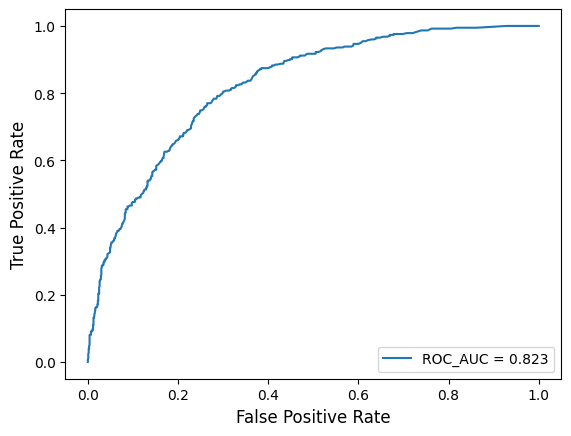

In [71]:
rf_pipe_pred_proba = rf_pipe.predict_proba(X_test)[:,1]

rf_pipe_roc_auc = metrics.roc_auc_score(Y_test, rf_pipe_pred_proba)
print('ROC_AUC: ', rf_pipe_roc_auc)

rf_pipe_fpr, rf_pipe_tpr, thresholds = metrics.roc_curve(Y_test, rf_pipe_pred_proba)

plt.plot(rf_pipe_fpr,rf_pipe_tpr, label = 'ROC_AUC = %0.3f' % rf_pipe_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

It did not go too well either. Let’s move on to the boosting models.

XGBoost

In [72]:
xgb_model = XGBClassifier(learning_rate = 0.05 ,random_state = 42, eval_metric = 'logloss')

params_xgb_list = [50,75,100,150,200,250]
param_xgb = 'n_estimators'
cv_function(xgb_model, param_xgb, params_xgb_list)

Hyperparameter:  n_estimators
Parameter: 50.00 - AUC(SD): 0.8437 (0.0165)
Parameter: 75.00 - AUC(SD): 0.8446 (0.0156)
Parameter: 100.00 - AUC(SD): 0.8444 (0.0153)
Parameter: 150.00 - AUC(SD): 0.8427 (0.0150)
Parameter: 200.00 - AUC(SD): 0.8406 (0.0149)
Parameter: 250.00 - AUC(SD): 0.8389 (0.0150)


In [75]:
xgb_param = {'n_estimators': 75}
xgb_model.set_params(**xgb_param) 
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [76]:
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=75, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

NameError: name 'nan' is not defined

In [77]:
xgb_model.fit(X_train, Y_train, eval_set = [(X_test,Y_test)])

pred_xgb = xgb_model.predict(X_test)

[0]	validation_0-logloss:0.67081
[1]	validation_0-logloss:0.65049
[2]	validation_0-logloss:0.63211
[3]	validation_0-logloss:0.61539
[4]	validation_0-logloss:0.60012
[5]	validation_0-logloss:0.58620
[6]	validation_0-logloss:0.57345
[7]	validation_0-logloss:0.56180
[8]	validation_0-logloss:0.55146
[9]	validation_0-logloss:0.54150
[10]	validation_0-logloss:0.53247
[11]	validation_0-logloss:0.52431
[12]	validation_0-logloss:0.51669
[13]	validation_0-logloss:0.50942
[14]	validation_0-logloss:0.50320
[15]	validation_0-logloss:0.49724
[16]	validation_0-logloss:0.49162
[17]	validation_0-logloss:0.48641
[18]	validation_0-logloss:0.48180
[19]	validation_0-logloss:0.47712
[20]	validation_0-logloss:0.47265
[21]	validation_0-logloss:0.46881
[22]	validation_0-logloss:0.46519
[23]	validation_0-logloss:0.46164
[24]	validation_0-logloss:0.45859
[25]	validation_0-logloss:0.45588
[26]	validation_0-logloss:0.45320
[27]	validation_0-logloss:0.45070
[28]	validation_0-logloss:0.44810
[29]	validation_0-loglos

In [78]:
print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_xgb))
print("Test F1 Score: ",metrics.f1_score(Y_test, pred_xgb))

Test Accuracy:  0.8062455642299503
Test F1 Score:  0.5991189427312775


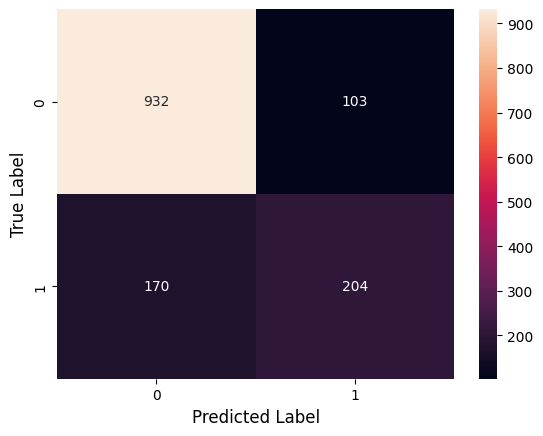

In [79]:
xgb_confusion_matrix = metrics.confusion_matrix(Y_test, pred_xgb)
sns.heatmap(xgb_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [80]:
print(metrics.classification_report(Y_test, pred_xgb, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



ROC_AUC:  0.8458833862925934


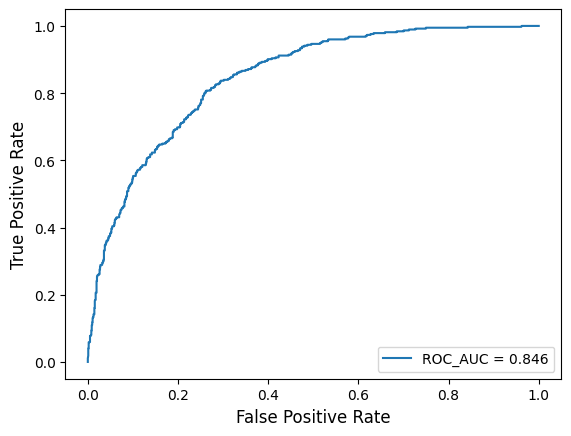

In [81]:
xgb_pred_proba = xgb_model.predict_proba(X_test)[:,1]

xgb_roc_auc = metrics.roc_auc_score(Y_test, xgb_pred_proba)
print('ROC_AUC: ', xgb_roc_auc)

xgb_fpr, xgb_tpr, thresholds = metrics.roc_curve(Y_test, xgb_pred_proba)

plt.plot(xgb_fpr,xgb_tpr, label = 'ROC_AUC = %0.3f' % xgb_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

Catboost

In [82]:
categorical_ft = [x for x in X.columns if x not in num_features]
print(categorical_ft)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [83]:
cat_model = CatBoostClassifier (random_state = 42, eval_metric = 'AUC', cat_features = categorical_ft, verbose = 0)

#cat_model.get_params()

params_cat_list = [50,75,100,150,200,250]
param_cat = 'n_estimators'
cv_function(cat_model, param_cat, params_cat_list)

Hyperparameter:  n_estimators
Parameter: 50.00 - AUC(SD): 0.8477 (0.0143)
Parameter: 75.00 - AUC(SD): 0.8481 (0.0139)
Parameter: 100.00 - AUC(SD): 0.8489 (0.0143)
Parameter: 150.00 - AUC(SD): 0.8488 (0.0138)
Parameter: 200.00 - AUC(SD): 0.8469 (0.0151)
Parameter: 250.00 - AUC(SD): 0.8464 (0.0142)


In [94]:
cat_param = {'n_estimators':100}
cat_model.set_params(**cat_param) 
#cat_model

CatBoostError: You can't change params of fitted model.

In [85]:
cat_model.fit(X_train, Y_train, eval_set = [(X_test,Y_test)], cat_features = categorical_ft)

pred_cat = cat_model.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat))
print("Test F1 Score: ",metrics.f1_score(Y_test, pred_cat))

Test Accuracy:  0.8126330731014905
Test F1 Score:  0.6106194690265487


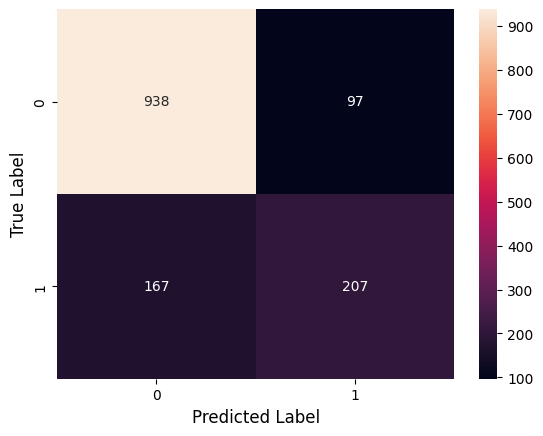

In [86]:
cat_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [87]:
print(metrics.classification_report(Y_test, pred_cat, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1035
           1       0.68      0.55      0.61       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409



ROC_AUC:  0.8489162727014391


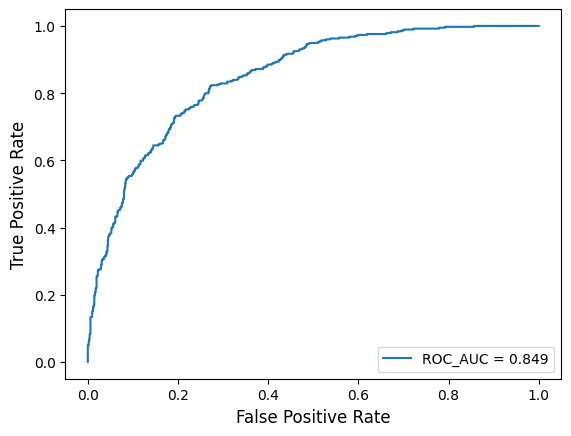

In [88]:
cat_pred_proba = cat_model.predict_proba(X_test)[:,1]

cat_roc_auc = metrics.roc_auc_score(Y_test, cat_pred_proba)
print('ROC_AUC: ', cat_roc_auc)

cat_fpr, cat_tpr, thresholds = metrics.roc_curve(Y_test, cat_pred_proba)

plt.plot(cat_fpr,cat_tpr, label = 'ROC_AUC = %0.3f' % cat_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

Results (AUC/accuracy/F1-Score):

Logistic Regression: 0.842/0.807/0.608
Random Forest: 0.825/0.788/0.554
Random Forest w/preprocessing: 0.823/0.780/0.545
XGBoost: 0.846/0.806/0.599
Catboost: 0.849/0.813/0.611

The Catboost yielded the best results, although they were quite close from those obtained with XGBoost and Logistic Regression.

Feature Importance and SHAP Plot

Let’s see what features have more importance for the Catboost’s predictions.

In [89]:
pool = Pool(X_train, Y_train, cat_features=categorical_ft)

Feature_importance = pd.DataFrame({'feature_importance': cat_model.get_feature_importance(pool), 
                      'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

Feature_importance

,feature_importance,feature_names
17,22.551466,MonthlyCharges
14,20.307516,Contract
4,19.186518,tenure
8,6.065405,OnlineSecurity
18,4.904298,TotalCharges
16,4.508491,PaymentMethod
11,4.420525,TechSupport
15,3.839855,PaperlessBilling
6,2.596800,MultipleLines
1,1.831362,SeniorCitizen


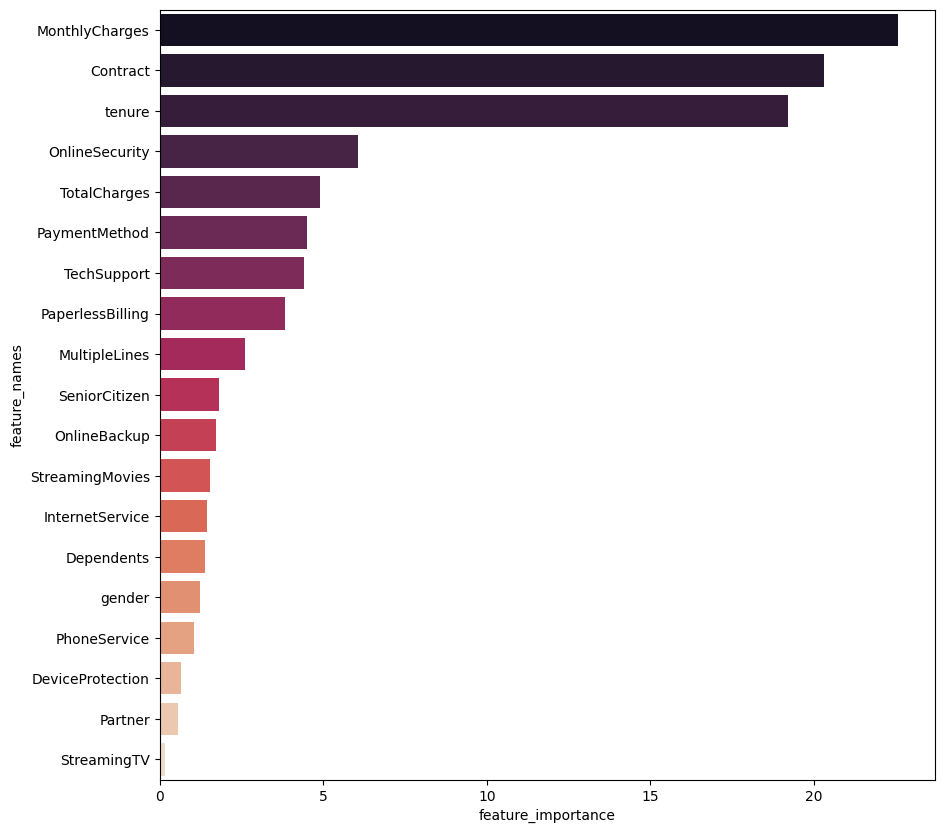

In [90]:
plt.figure(figsize=(10,10))

sns.barplot(x=Feature_importance['feature_importance'], y=Feature_importance['feature_names'], palette = 'rocket')

plt.show()

To better interpret the model’s results, and maybe gain some insights, we can use the SHAP package (link).

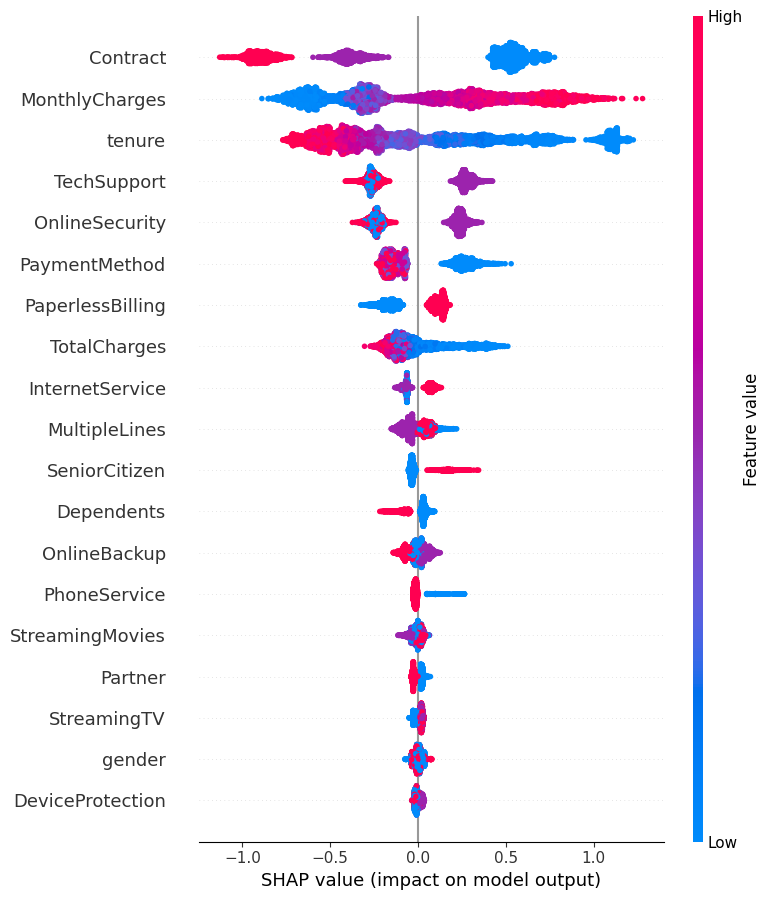

In [91]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(pool)

shap.summary_plot(shap_values, X_train)

Since we manually encoded the categorical features, it becomes easier to understand what’s been represented in each category. For instance, the feature ‘contract’ has 3 categories. ‘Month-to-month’ was encoded with the lowest value and it’s represented by the blue color. ‘One year’ is the mid value and it’s represented in purple. ‘Two years’ is the highest value and is represented in red. We can clearly see that the ‘month-to-month’ category impacts the prediction towards the positive value (churn), while the other types of contracts push the prediction into the opposite direction (no churn).

The three features that have the most impact on the model’s predictions are related to the account information (Contract, Monthly Chargers and Tenure).

Among the service-related features, the most important are ‘Tech Support’ and ‘Online Security’. Per our encoding, the purple color represents the clients who subscribe to Telco’s internet, but don’t have the mentioned additional service. We can see that the model assigns a higher probability of churn to those customers. This result follows what we discovered on the EDA stage and highlights the discussion about new strategies involving those services.

Among the demographic features, ‘Senior Citizen’ and ‘Dependents’ have some significative impact on the model’s predictions.

About Class Imbalance

As shown in the beginning of the EDA stage, the dataset is imbalanced. 26,5% of the samples represent customers who left in the last month. Such imbalance is somewhat expected, given the nature of this problem, but it comes with issue that the predictions will be biased towards the majority class. Neither one of the models were able to reach a recall of 56%+, which means that if we were to use the ‘hard’ (0 or 1) predictions to target customers that were close to churn, we would miss almost half of them. There are a few options to deal with class imbalance, such as:

Apply Oversampling/Undersampling: Generate new samples for the minority class or remove some samples from the majority class in order to have a balanced dataset;

Tune the ‘class weighting’ hyperparameter: Some models have a specific hyperparameter (e.g.: XGBoost’s ‘scale_pos_weight’) which can be used to assign a higher weight to the misclassification of a minority class sample;

Adjust the classification threshold: The default threshold for binary classification models is 50%. Instead of using the hard predictions, we can get the probabilities of churn for each sample and classify them based on a custom threshold.

The last technique, although simple, can be quite effective depending on the goal. We can tune the threshold, for instance, to optimize the F1 score or to find the best recall at a minimum expected value for precision.

This notebook will be updated on a near feature to present how we can optimize the threshold. For now, I’ll be showing a quick example of how using a custom threshold can affect the classification metrics.

Let’s get the probabilities found by the CatBoost and classify the test set using a threshold of 25%.

In [92]:
custom_th_pred= np.where(cat_pred_proba>0.250, 1, 0)
print(metrics.classification_report(Y_test, custom_th_pred, labels = [0, 1], digits = 3))

              precision    recall  f1-score   support

           0      0.919     0.720     0.807      1035
           1      0.515     0.824     0.634       374

    accuracy                          0.747      1409
   macro avg      0.717     0.772     0.720      1409
weighted avg      0.811     0.747     0.761      1409



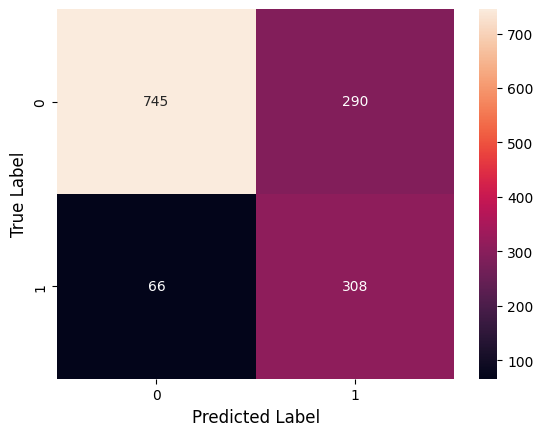

In [93]:
prob_confusion_matrix = metrics.confusion_matrix(Y_test, custom_th_pred)
sns.heatmap(prob_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

We were able to find a recall of 82.4%, against less than 56% from the original predictions. Of course, there is a tradeoff involved. Reducing the threshold comes with the downside of losing precision. Yet, the F1-score was also better with the custom threshold (0.634 vs 0.611).

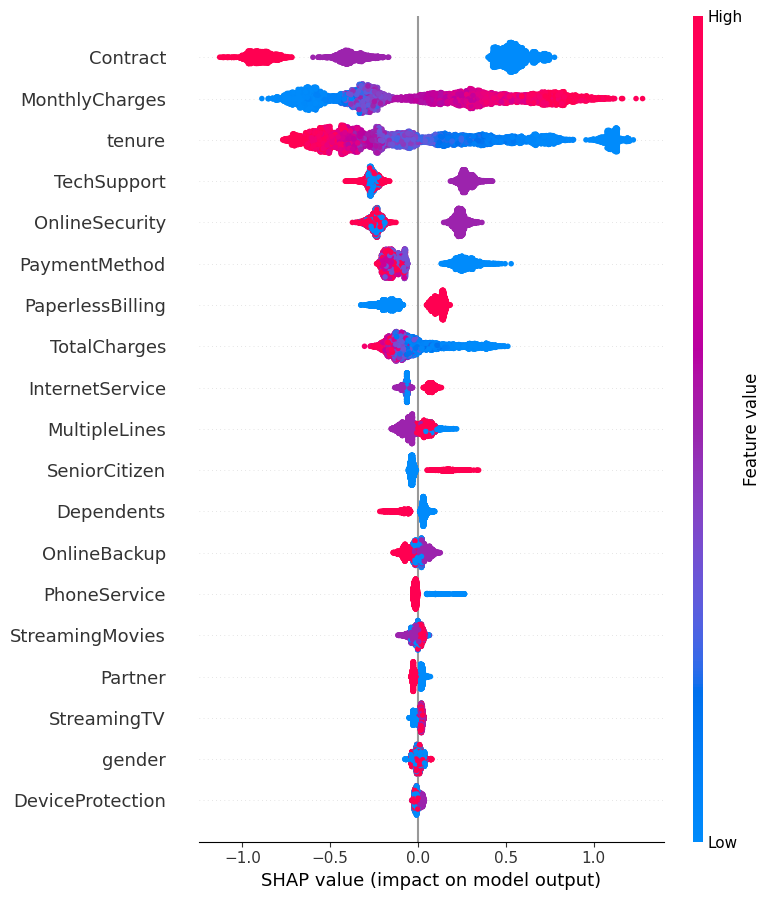

In [106]:
#from explainerdashboard import TreeExplainer, ExplainerDashboard
#import dash_bootstrap_components as dbc



explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(pool)

shap.summary_plot(shap_values, X_train)

#from explainerdashboard import ClassifierExplainer, ExplainerDashboard

#explainer1 = ClassifierExplainer(pool, X_train)
#ExplainerDashboard(explainer1).run()

#db = ExplainerDashboard(explainer, 
                        #title="Customer Churn", # defaults to "Model Explainer"
                        #whatif=False
                        
                        #)
#db.run(port=3051)